# US Name
Estimate kandhelwal_quality as a function of  ln_lag_tax_rebate and others variables


# Description

- Change sign for story
- Check sign price adjusted
- Estimate table 1
- Estimate table 2
- Estimate table 4
- Estimate table 5

## Variables
### Target

kandhelwal_quality

### Features

- ln_lag_tax_rebate
- regime
- ln_lag_import_tax

## Complementary information



# Metadata

- Key: 198_VAT_rebate_quality
- Epic: Models
- US: Baseline table
- Task tag: #data-analysis
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name**

- china_vat_quality

**Github**

- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/04_baseline_vat_quantity_covariates.md



# Connexion server

In [2]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys
import janitor

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [3]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [4]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [6]:
change_target <- function(table){
    ## Regime
    check_target <- grep("regimeELIGIBLE:ln_lag_import_tax", rownames(table$coef))
    
    if (length(check_target) !=0) {
    ## SOE
    rownames(table$coefficients)[check_target] <- 'ln_lag_import_tax:regimeELIGIBLE'
    rownames(table$beta)[check_target] <- 'ln_lag_import_tax:regimeELIGIBLE'
    } 
    return (table)
}

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [7]:
db = 'chinese_trade'
table = 'china_vat_quality'

In [8]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)',
                         'varchar(11)',
                        'array<bigint>',
                        'map<double,boolean>']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [9]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT 
  * 
FROM 
  chinese_trade.china_vat_quality 
  LEFT JOIN (
    SELECT 
      * 
    FROM 
      (
        SELECT 
          year, 
          hs6, 
          geocode4_corr, 
          country_en, 
          COUNT(
            DISTINCT(regime)
          ) as cn 
        FROM 
          chinese_trade.china_vat_quality 
        GROUP BY 
          year, 
          hs6, 
          geocode4_corr, 
          country_en
      )
  ) as cn on china_vat_quality.year = cn.year 
  and china_vat_quality.hs6 = cn.hs6
  and china_vat_quality.geocode4_corr = cn.geocode4_corr
  and china_vat_quality.country_en = cn.country_en 
  WHERE cn = 2
    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
    except:
        pass
    #s3.download_file(
    #    key = full_path_filename
    #)
    #shutil.move(
    #    filename + '.csv',
    #    os.path.join(path_local, filename + '.csv')
    #)
    #s3.remove_file(full_path_filename)
    

In [10]:
pd.DataFrame(schema)

,Name,Type,Comment
0,geocode4_corr,string,city name
1,year,string,year
2,regime,varchar(12),eligible or no eligible to vat rebate
3,hs6,string,HS6 6 digit
4,hs4,string,HS4 4 digit
5,hs3,string,HS3 3 digit
6,hs2,string,HS2 2 digit
7,homogeneous,string,Goods label
8,country_en,string,English country name
9,iso_alpha,string,


In [11]:
query = """
SELECT * FROM "trade"."wto_wiiw_ntm"
"""
df_ntm = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
          .assign(
        year_initiation = lambda x: x['year_initiation'].astype('Int64'),#.astype(str),
        year_withdrawal = lambda x: x['year_withdrawal'].astype('Int64').astype(str)
    )
          .rename(columns = {"imp_iso3":"iso_alpha", "year_initiation":'year'})
                )
df_ntm.head(2)

,id,imp,iso_alpha,aff,aff_iso3,ntm,sub,stc,date_initiation,date_inforce,date_withdrawal,year,year_inforce,year_withdrawal,doc,hsorigin,dborigin,measuredesc,proddesc,keywords,id_ttbd,hs1996,hs_combined
0,21956,European Union,EUN,All Members,WTO,TBT,Regular,0.0,26apr2012,NaN,NaN,2012,NaN,<NA>,GTBTNEU39,MIS,itip,draft commission regulation establishing criteria determining when recovered paper ceases to be waste under directive 2008 98 ec of the european parliament and of the council 10 pages in english this draft regulation establishes criteria on the quality of recovered paper in order for it to cease to be waste,recovered paper,Protection of Human health or safety Protection of the environment,NaN,NaN,NaN
1,21957,European Union,EUN,All Members,WTO,TBT,Regular,0.0,27apr2012,NaN,NaN,2012,NaN,<NA>,GTBTNEU40,DES,itip,draft commission regulation amending annexes ii iii v and vi to regulation ec no 1223 2009 of the european parliament and of the council on cosmetic products 112 pages in english the proposed draft regulation aims at transferring into the annexes to regulation ec no 1223 2009 on cosmetic products the amendments to the annexes to council directive 76 768 eec adopted since 5 february 2008 ie the date when the commission proposal for a regulation replacing the directive was adopted,cosmetic products,Human health Protection of Human health or safety,NaN,330300|330410|330420|330430|330491|330499|330510|330520|330530|330590|330610|330620|330690|330710|330720|330730|330741|330749|330790,330300|330410|330420|330430|330491|330499|330510|330520|330530|330590|330610|330620|330690|330710|330720|330730|330741|330749|330790


In [12]:
df_ntm.to_csv('ntm.csv')

# Compute NTM and quality variables

## NTM 

### China import and world

In [13]:
df.shape

(639722, 38)

In [14]:
df_ntm.dropna(subset = ['year']).shape

(60454, 23)

In [15]:
df_ntm_world = (
    df_ntm
    .loc[lambda x: x['ntm'].isin([
        'TBT',
        #'SPS',
        'ADP'
    ])]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .dropna(subset = ['year'])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .reset_index()
    
    .pivot_table(
        values="count",
        index=["iso_alpha","hs6"],
        columns="year",
        aggfunc="sum",
        fill_value=0,
    )
    .stack()
    .reset_index()
    .rename(columns={0: "count_ntm"})
    .assign(
        stock_ntm=lambda x: x.groupby(["iso_alpha","hs6"])[
            "count_ntm"
        ].transform("cumsum"),
        new_ntm=lambda x: np.where(x["count_ntm"] > 0, 'TRUE', 'FALSE'),
        active_ntm=lambda x: np.where(x["stock_ntm"] > 0, 'TRUE', 'FALSE'),
    )
    #.loc[lambda x: x['hs6'].isin(['400270'])]

)
df_ntm_world[["count_ntm",'stock_ntm','new_ntm','active_ntm']].describe()

,count_ntm,stock_ntm
count,1.088307e+07,1.088307e+07
mean,2.597155e-01,2.485065e+00
std,1.176793e+00,7.766679e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+00
max,6.800000e+01,4.030000e+02


In [16]:
df_ntm_world[['new_ntm']].value_counts()

new_ntm
FALSE      9672345
TRUE       1210727
dtype: int64

In [17]:
df_ntm_world[['active_ntm']].value_counts()

active_ntm
FALSE         5929612
TRUE          4953460
dtype: int64

In [18]:
df_ntm_china =(
    df_ntm_world
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    .rename(
    columns = {
        'count_ntm':'count_ntm_china',
        'stock_ntm':'stock_ntm_china',
        'new_ntm':'new_ntm_china',
        'active_ntm':'active_ntm_china',
    })
)
df_ntm_china.head()

,iso_alpha,hs6,year,count_ntm_china,stock_ntm_china,new_ntm_china,active_ntm_china
1728064,CHN,010110,1985,0,0,FALSE,FALSE
1728065,CHN,010110,1989,0,0,FALSE,FALSE
1728066,CHN,010110,1990,0,0,FALSE,FALSE
1728067,CHN,010110,1991,0,0,FALSE,FALSE
1728068,CHN,010110,1992,0,0,FALSE,FALSE


- 1) ADP - Antidumping # CHINA
- 2) CVD - Countervailing duties
- 3) EXS - Export subsidies
- 4) QRS - Quantitative Restrictions
- 5) SFG - Safeguards
- 6) SPS - Sanitary and Phytosanitary Measures # CHINA
- 7) SSG - Special Safeguards (agriculture)
- 8) STE - State trading enterprises
- 9) TBT - Technical barriers to trade # CHINA
- 10) TRQ - Tariff-rate quotas

----- 

- count_ntm_china:  Number of new policy per year
- stock_ntm_china:  Number of active policy 
- new_ntm_china: Equal to 1 if a new policy is added
- active_ntm_china: Equal to 1 if the policy is active

In [19]:
df_ntm.loc[lambda x: x["iso_alpha"].isin(["CHN"])]['aff'].value_counts()

All Members       2758
United States      117
European Union      97
Japan               87
South Korea         70
Taiwan              23
Canada              22
India               16
Australia           14
Russia              14
Singapore           13
Thailand            12
Malaysia            11
Indonesia           11
Switzerland          9
Brazil               7
Mexico               6
Germany              6
New Zealand          5
Saudi Arabia         5
United Kingdom       4
Netherlands          4
Argentina            3
Norway               3
Finland              3
France               3
Belgium              2
Ukraine              2
Israel               2
South Africa         2
Hong Kong            2
Macao                2
Italy                2
Denmark              1
Austria              1
Slovenia             1
Belarus              1
Poland               1
Latvia               1
Estonia              1
Romania              1
Turkey               1
Czech Republic       1
Croatia    

In [20]:
#(
#    df_ntm
#    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
#    .loc[lambda x: x['ntm'].isin(['TBT'])]
#)

In [21]:
list_ntm = []
for i in [["TBT"], ["SPS"], ["TBT", "SPS"], ["ADP"]]:
    df_temp = (
        df_ntm.loc[lambda x: x["iso_alpha"].isin(["CHN"])]
        .loc[lambda x: x["ntm"].isin(i)]
        .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
        .dropna(subset=["year"])
        .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
        .explode("hs6")
        .groupby(["iso_alpha", "year", "hs6"])
        .agg({"id": "nunique"})
        .rename(columns={"id": "count"})
        .sort_values(by=["iso_alpha", "year", "hs6"])
        .reset_index()
        .pivot_table(
            values="count",
            index=["iso_alpha", "hs6"],
            columns="year",
            aggfunc="sum",
            fill_value=0,
        )
        .stack()
        .reset_index()
        .rename(columns={0: "count_ntm_china"})
        .assign(
            stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["count_ntm_china"].transform(
                "cumsum"
            ),
            new_ntm_china=lambda x: np.where(x["count_ntm_china"] > 0, "TRUE", "FALSE"),
            active_ntm_china=lambda x: np.where(x["stock_ntm_china"] > 0, "TRUE", "FALSE"),
        )
        .assign(
            lag_count_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["count_ntm_china"]
            .transform("shift")
            .fillna(0),
            lag_stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["stock_ntm_china"]
            .transform("shift")
            .fillna(0),
            lag_new_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["new_ntm_china"]
            .transform("shift")
            .fillna("FALSE"),
            lag_active_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["active_ntm_china"]
            .transform("shift")
            .fillna("FALSE"),
        )
        .reset_index()
        .rename(
            columns={
                "count_ntm_china": "c_count_ntm_{}_china".format("_".join(i)),
                "lag_count_ntm_china": "c_lag_count_ntm_{}_china".format("_".join(i)),
                "stock_ntm_china": "c_stock_ntm_{}_china".format("_".join(i)),
                "lag_stock_ntm_china": "c_lag_stock_ntm_{}_china".format("_".join(i)),
                "new_ntm_china": "new_ntm_{}_china".format("_".join(i)),
                "lag_new_ntm_china": "lag_new_ntm_{}_china".format("_".join(i)),
                "active_ntm_china": "active_ntm_{}_china".format("_".join(i)),
                "lag_active_ntm_china": "lag_active_ntm_{}_china".format("_".join(i)),
            }
        )
        .drop(columns = ['index'])
    )
    list_ntm.append(df_temp)
len(list_ntm)

4

In [22]:
list_ntm[1]

,iso_alpha,hs6,year,c_count_ntm_SPS_china,c_stock_ntm_SPS_china,new_ntm_SPS_china,active_ntm_SPS_china,c_lag_count_ntm_SPS_china,c_lag_stock_ntm_SPS_china,lag_new_ntm_SPS_china,lag_active_ntm_SPS_china
0,CHN,010110,2002,9,9,TRUE,TRUE,0.0,0.0,FALSE,FALSE
1,CHN,010110,2003,1,10,TRUE,TRUE,9.0,9.0,TRUE,TRUE
2,CHN,010110,2004,0,10,FALSE,TRUE,1.0,10.0,TRUE,TRUE
3,CHN,010110,2005,1,11,TRUE,TRUE,0.0,10.0,FALSE,TRUE
4,CHN,010110,2006,0,11,FALSE,TRUE,1.0,11.0,TRUE,TRUE
...,...,...,...,...,...,...,...,...,...,...,...
41647,CHN,843890,2015,52,169,TRUE,TRUE,10.0,117.0,TRUE,TRUE
41648,CHN,843890,2016,2,171,TRUE,TRUE,52.0,169.0,TRUE,TRUE
41649,CHN,843890,2017,2,173,TRUE,TRUE,2.0,171.0,TRUE,TRUE
41650,CHN,843890,2018,4,177,TRUE,TRUE,2.0,173.0,TRUE,TRUE


In [23]:
dvl_econ = [
    'United States',
    'European Union',
    'Japan',
    'South Korea',
    'Canada',
    'Australia',
    'Switzerland',
    'Germany',
    'New Zealand',
    'Netherlands',
    'United Kingdom',
    'Norway',
    'Finland',
    'France',
    'Italy',
    'Belgium',
    'Israel',
    'Sweden',
    'Denmark',
    'Austria'
]

df_country = (
    df_ntm
    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x['aff'].isin(dvl_econ)]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
        .dropna(subset=["year"])
        .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
        .explode("hs6")
        .groupby(["iso_alpha", "year", "hs6"])
        .agg({"id": "nunique"})
        .rename(columns={"id": "count"})
        .sort_values(by=["iso_alpha", "year", "hs6"])
        .reset_index()
        .pivot_table(
            values="count",
            index=["iso_alpha", "hs6"],
            columns="year",
            aggfunc="sum",
            fill_value=0,
        )
        .stack()
        .reset_index()
        .rename(columns={0: "count_ntm_china"})
        .assign(
            stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["count_ntm_china"].transform(
                "cumsum"
            ),
            new_ntm_china=lambda x: np.where(x["count_ntm_china"] > 0, "TRUE", "FALSE"),
            active_ntm_china=lambda x: np.where(x["stock_ntm_china"] > 0, "TRUE", "FALSE"),
        )
        .assign(
            lag_count_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["count_ntm_china"]
            .transform("shift")
            .fillna(0),
            lag_stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["stock_ntm_china"]
            .transform("shift")
            .fillna(0),
            lag_new_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["new_ntm_china"]
            .transform("shift")
            .fillna("FALSE"),
            lag_active_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["active_ntm_china"]
            .transform("shift")
            .fillna("FALSE"),
        )
        .reset_index()
        .rename(
            columns={
                "count_ntm_china": "c_count_ntm_dvp_china",
                "lag_count_ntm_china": "c_lag_count_ntm_dvp_china",
                "stock_ntm_china": "c_stock_ntm_dvp_china",
                "lag_stock_ntm_china": "c_lag_stock_ntm_dvp_china",
                "new_ntm_china": "new_ntm_dvp_china",
                "lag_new_ntm_china": "lag_new_ntm_dvp_china",
                "active_ntm_china": "active_ntm_dvp_china",
                "lag_active_ntm_china": "lag_active_ntm_dvp_china"
            }
        )
    .drop(columns = ['index'])
    )
df_country.head(1)

,iso_alpha,hs6,year,c_count_ntm_dvp_china,c_stock_ntm_dvp_china,new_ntm_dvp_china,active_ntm_dvp_china,c_lag_count_ntm_dvp_china,c_lag_stock_ntm_dvp_china,lag_new_ntm_dvp_china,lag_active_ntm_dvp_china
0,CHN,020710,1997,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE


In [24]:
#list_ntm_c[1]

In [25]:
list_env = [
    "Protection of the environment",
#"Protection of the environment Quality requirements",
#"Protection of the environment Safety",
#"Protection of the environment Trade facilitation"
]

df_ntm_env = (
    df_ntm
    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x['keywords'].isin(list_env)]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
        .dropna(subset=["year"])
        .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
        .explode("hs6")
        .groupby(["iso_alpha", "year", "hs6"])
        .agg({"id": "nunique"})
        .rename(columns={"id": "count"})
        .sort_values(by=["iso_alpha", "year", "hs6"])
        .reset_index()
        .pivot_table(
            values="count",
            index=["iso_alpha", "hs6"],
            columns="year",
            aggfunc="sum",
            fill_value=0,
        )
        .stack()
        .reset_index()
        .rename(columns={0: "count_ntm_china"})
        .assign(
            stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["count_ntm_china"].transform(
                "cumsum"
            ),
            new_ntm_china=lambda x: np.where(x["count_ntm_china"] > 0, "TRUE", "FALSE"),
            active_ntm_china=lambda x: np.where(x["stock_ntm_china"] > 0, "TRUE", "FALSE"),
        )
        .assign(
            lag_count_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["count_ntm_china"]
            .transform("shift")
            .fillna(0),
            lag_stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["stock_ntm_china"]
            .transform("shift")
            .fillna(0),
            lag_new_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["new_ntm_china"]
            .transform("shift")
            .fillna("FALSE"),
            lag_active_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])["active_ntm_china"]
            .transform("shift")
            .fillna("FALSE"),
        )
        .reset_index()
        .rename(
            columns={
                "count_ntm_china": "c_count_ntm_env_china",
                "lag_count_ntm_china": "c_lag_count_ntm_env_china",
                "stock_ntm_china": "c_stock_ntm_env_china",
                "lag_stock_ntm_china": "c_lag_stock_ntm_env_china",
                "new_ntm_china": "new_ntm_env_china",
                "lag_new_ntm_china": "lag_new_ntm_env_china",
                "active_ntm_china": "active_ntm_env_china",
                "lag_active_ntm_china": "lag_active_ntm_env_china"
            }
        )
    .drop(columns = ['index'])
    )
df_ntm_env.head(1)

,iso_alpha,hs6,year,c_count_ntm_env_china,c_stock_ntm_env_china,new_ntm_env_china,active_ntm_env_china,c_lag_count_ntm_env_china,c_lag_stock_ntm_env_china,lag_new_ntm_env_china,lag_active_ntm_env_china
0,CHN,220720,2008,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE


Compute frequency, coverage and prevalence ratio:

- D is a dummy variable reflecting the presence of one or more NTMs
- M indicates whether there are imports of good i (also a dummy variable)
- V is the value of imports in product i.
- N is the number of NTMs on product i

To make things simpler, we create different queries

In [26]:
query = """
SELECT DISTINCT(hs6), t as year
FROM baci_2002_2020
WHERE 
    t IN (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010', '2011'
    ) 
GROUP BY t, hs6
"""
df_hs_baci = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
)
              .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
       )


In [27]:
query = """
SELECT 
    DISTINCT(hs6) as hs6,
    t as year, 
    iso_3digit_alpha_d
    
  FROM 
    "trade"."baci_2002_2020" 
  WHERE 
    t IN (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010', '2011'
    ) 
  GROUP BY 
    t, 
    iso_3digit_alpha_d,hs6
"""
df_M = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
        .dropna(subset = ['year', 'iso_3digit_alpha_d'])
        .rename(columns={"iso_3digit_alpha_d": "iso_alpha"})
        .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
       )
df_M.head()

,hs6,year,iso_alpha
0,020230,2002,CHL
1,020230,2002,CUB
2,020230,2002,NGA
3,020230,2002,VNM
4,080232,2002,ZAF


In [28]:
query = """
SELECT 
    t as year, 
    iso_3digit_alpha_d, 
    hs6,
    SUM(v) as v
  FROM 
    "trade"."baci_2002_2020" 
  WHERE 
    t IN (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010', '2011'
    ) 
  GROUP BY 
    t, 
    iso_3digit_alpha_d,
    hs6
"""
df_V = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
)
              .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
        .rename(columns={"iso_3digit_alpha_d": "iso_alpha"})
       )
df_V.head()

,year,iso_alpha,hs6,v
0,2002,KWT,020230,7374
1,2002,NRU,080232,54
2,2002,LBY,121190,228
3,2002,BFA,121190,6
4,2002,BRN,121190,60


Frequency

In [29]:
df_freq =(
    df_ntm_world
    .loc[lambda x: ~x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x["active_ntm"].isin(["TRUE"])]
    .merge(df_M)
    .groupby(['year', 'iso_alpha'])
    .agg({'hs6':'nunique'})
    .rename(columns = {'hs6':'DM'})
    .merge((df_M.groupby(['year', 'iso_alpha'])).agg({'hs6':'count'}).rename(columns = {'hs6':'M'}),
           left_index = True, right_index = True,how = 'right')
    .assign(DM=lambda x: x["DM"].fillna(0), F=lambda x: x["DM"] / x["M"])
    .reset_index()
    .sort_values(by=["iso_alpha", "year"])
    .assign(
        lag_DM=lambda x: x.groupby(["iso_alpha",])["DM"].transform("shift"),
        lag_F=lambda x: x.groupby(["iso_alpha",])["F"].transform("shift")
    )
)
df_freq[['DM','M','F','lag_DM','lag_F']].describe()

,DM,M,F,lag_DM,lag_F
count,2220.000000,2220.000000,2220.000000,1994.000000,1994.000000
mean,619.910811,3606.215766,0.130689,604.774824,0.126986
std,1239.396495,1361.933864,0.255228,1235.230719,0.253411
min,0.000000,2.000000,0.000000,0.000000,0.000000
25%,0.000000,2669.750000,0.000000,0.000000,0.000000
50%,0.000000,4107.500000,0.000000,0.000000,0.000000
75%,704.000000,4727.500000,0.154663,621.500000,0.146474
max,5201.000000,5217.000000,1.000000,5201.000000,1.000000


Coverage

In [30]:
df_cov = (
    df_ntm_world
    .loc[lambda x: ~x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x["active_ntm"].isin(["TRUE"])]
    .merge(df_V)
    .groupby(['year', 'iso_alpha'])
    .agg({'v':'sum'})
    .rename(columns = {'v':'DV'})
    .merge((df_V.groupby(['year', 'iso_alpha'])).agg({'v':'sum'}).rename(columns = {'v':'V'}),
           left_index = True, right_index = True,how = 'right')
    .assign(DV=lambda x: x["DV"].fillna(0), C=lambda x: x["DV"] / x["V"])
    .reset_index()
    .sort_values(by=["iso_alpha", "year"])
    .assign(
        lag_DV=lambda x: x.groupby(["iso_alpha",])["DV"].transform("shift"),
        lag_C=lambda x: x.groupby(["iso_alpha",])["C"].transform("shift")
    )
)
df_cov[['DV','V','C','lag_DV','lag_C']].describe()

,DV,V,C,lag_DV,lag_C
count,2.220000e+03,2.220000e+03,2220.000000,1.994000e+03,1994.000000
mean,2.380588e+07,5.349904e+07,0.150490,2.237232e+07,0.146065
std,1.189719e+08,1.651438e+08,0.277075,1.135205e+08,0.274468
min,0.000000e+00,1.200000e+01,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,7.887078e+05,0.000000,0.000000e+00,0.000000
50%,0.000000e+00,4.572448e+06,0.000000,0.000000e+00,0.000000
75%,2.491546e+06,2.504954e+07,0.170413,2.024588e+06,0.149975
max,2.022994e+09,2.129602e+09,1.000000,1.873482e+09,1.000000


Prevalence

In [31]:
df_prev = (
    df_ntm_world
    .loc[lambda x: ~x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x["active_ntm"].isin(["TRUE"])]
    .merge(df_M)
    .groupby(['year', 'iso_alpha'])
    .agg({'stock_ntm':'sum'})
    .rename(columns = {'stock_ntm':'NM'})
    .merge((df_M.groupby(['year', 'iso_alpha'])).agg({'hs6':'count'}).rename(columns = {'hs6':'M'}),
           left_index = True, right_index = True,how = 'right')
    .assign(NM=lambda x: x["NM"].fillna(0), P=lambda x: x["NM"] / x["M"])
    .reset_index()
    .sort_values(by=["iso_alpha", "year"])
    .assign(
        lag_NM=lambda x: x.groupby(["iso_alpha",])["NM"].transform("shift"),
        lag_P=lambda x: x.groupby(["iso_alpha",])["P"].transform("shift")
    )
    .drop(columns = ['M'])
)
df_prev[['NM','P','lag_NM','lag_P']].describe()

,NM,P,lag_NM,lag_P
count,2220.000000,2220.000000,1994.000000,1994.000000
mean,2471.476577,0.510390,2331.312939,0.478440
std,8286.598468,1.676011,8043.032796,1.615928
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,828.000000,0.178544,799.750000,0.171930
max,90614.000000,18.083471,90614.000000,17.949030


In [32]:
df_prev

,year,iso_alpha,NM,P,lag_NM,lag_P
0,2002,ABW,0.0,0.0,NaN,NaN
221,2003,ABW,0.0,0.0,0.0,0.0
442,2004,ABW,0.0,0.0,0.0,0.0
663,2005,ABW,0.0,0.0,0.0,0.0
884,2006,ABW,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1327,2007,ZWE,0.0,0.0,0.0,0.0
1549,2008,ZWE,0.0,0.0,0.0,0.0
1771,2009,ZWE,0.0,0.0,0.0,0.0
1994,2010,ZWE,0.0,0.0,0.0,0.0


### Merge all NTM

In [33]:
(
            df_ntm_world.assign(
                c_lag_count_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "count_ntm"
                ]
                .transform("shift")
                .fillna(0),
                c_lag_stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "stock_ntm"
                ]
                .transform("shift")
                .fillna(0),
                c_lag_new_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "new_ntm"
                ]
                .transform("shift")
                .fillna("FALSE"),
                c_lag_active_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "active_ntm"
                ]
                .transform("shift")
                .fillna("FALSE"),
            )
            .rename(
                columns={
                    "count_ntm": "c_count_ntm",
                    "stock_ntm": "c_stock_ntm",
                }
            )
        )

,iso_alpha,hs6,year,c_count_ntm,c_stock_ntm,new_ntm,active_ntm,c_lag_count_ntm,c_lag_stock_ntm,c_lag_new_ntm,c_lag_active_ntm
0,AFG,252310,1985,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE
1,AFG,252310,1989,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE
2,AFG,252310,1990,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE
3,AFG,252310,1991,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE
4,AFG,252310,1992,0,0,FALSE,FALSE,0.0,0.0,FALSE,FALSE
...,...,...,...,...,...,...,...,...,...,...,...
10883067,ZMB,970600,2015,0,1,FALSE,TRUE,0.0,1.0,FALSE,TRUE
10883068,ZMB,970600,2016,0,1,FALSE,TRUE,0.0,1.0,FALSE,TRUE
10883069,ZMB,970600,2017,0,1,FALSE,TRUE,0.0,1.0,FALSE,TRUE
10883070,ZMB,970600,2018,0,1,FALSE,TRUE,0.0,1.0,FALSE,TRUE


In [34]:
df_final = (
    df.drop(columns=["year.1", "hs6.1", "geocode4_corr.1", "country_en.1"])
    .assign(hs6=lambda x: x["hs6"].astype(str).str.zfill(6))
    .merge(df_ntm_world, on=["iso_alpha", "year", "hs6"], how="left")
    .merge(
        (
            df_ntm_china.assign(
                c_lag_count_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "count_ntm_china"
                ]
                .transform("shift")
                .fillna(0),
                c_lag_stock_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "stock_ntm_china"
                ]
                .transform("shift")
                .fillna(0),
                lag_new_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "new_ntm_china"
                ]
                .transform("shift")
                .fillna("FALSE"),
                lag_active_ntm_china=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "active_ntm_china"
                ]
                .transform("shift")
                .fillna("FALSE"),
            )
            .rename(
                columns={
                    "count_ntm_china": "c_count_ntm_china",
                    "stock_ntm_china": "c_stock_ntm_china",
                }
            )
            .drop(columns=["iso_alpha"])
        ),
        on=["year", "hs6"],
        how="left",
    )
    .merge(df_ntm_env.drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[0].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[1].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[2].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[3].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(df_country.drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(df_freq, on=["year", "iso_alpha"], how="left",)
    .merge(df_prev, on=["year", "iso_alpha"], how="left",)
    .merge(df_cov, on=["year", "iso_alpha"], how="left",)
    .merge(
    (
            df_ntm_world.assign(
                c_lag_count_ntm_w=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "count_ntm"
                ]
                .transform("shift")
                .fillna(0),
                c_lag_stock_ntm_w=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "stock_ntm"
                ]
                .transform("shift")
                .fillna(0),
                lag_new_ntm_w=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "new_ntm"
                ]
                .transform("shift")
                .fillna("FALSE"),
                lag_active_ntm_w=lambda x: x.groupby(["iso_alpha", "hs6"])[
                    "active_ntm"
                ]
                .transform("shift")
                .fillna("FALSE"),
            )
            .rename(
                columns={
                    "count_ntm": "c_count_ntm_w",
                    "stock_ntm": "c_stock_ntm_w",
                    "new_ntm": "new_ntm_w",
                    "active_ntm": "active_ntm_w",
                }
            )
        ), on=["year", "iso_alpha", "hs6"], how="left"
    )
)
df_final = df_final.assign(
    **{
        "{}".format(i): df_final[i].fillna(0)
        for i in list(df_final.filter(regex="^c_").columns)
        + [
            "DM",
            "M",
            "F",
            "lag_DM",
            "lag_F",
            "NM",
            "P",
            "lag_NM",
            "lag_P",
            "DV",
            "V",
            "C",
            "lag_DV",
            "lag_C",
        ]
    },
    **{
        "{}".format(i): df_final[i].fillna("FALSE")
        for i in list(df_final.filter(regex="new|active").columns)
    },
)
df_final.head(1)

,geocode4_corr,year,regime,hs6,hs4,hs3,hs2,homogeneous,country_en,iso_alpha,gni_per_capita,gpd_per_capita,income_group,income_group_ldc_dc,quantity,value,unit_price,kandhelwal_quality,price_adjusted_quality,lag_vat_m,lag_vat_reb_m,lag_tax_rebate,ln_lag_vat_m,ln_lag_vat_reb_m,ln_lag_tax_rebate,lag_import_tax,ln_lag_import_tax,lag_soe_export_share_ckr,lag_foreign_export_share_ckr,high_tech,energy,skilled,rd_oriented,cn,count_ntm,stock_ntm,new_ntm,active_ntm,c_count_ntm_china,c_stock_ntm_china,new_ntm_china,active_ntm_china,c_lag_count_ntm_china,c_lag_stock_ntm_china,lag_new_ntm_china,lag_active_ntm_china,c_count_ntm_env_china,c_stock_ntm_env_china,new_ntm_env_china,active_ntm_env_china,c_lag_count_ntm_env_china,c_lag_stock_ntm_env_china,lag_new_ntm_env_china,lag_active_ntm_env_china,c_count_ntm_TBT_china,c_stock_ntm_TBT_china,new_ntm_TBT_china,active_ntm_TBT_china,c_lag_count_ntm_TBT_china,c_lag_stock_ntm_TBT_china,lag_new_ntm_TBT_china,lag_active_ntm_TBT_china,c_count_ntm_SPS_china,c_stock_ntm_SPS_china,new_ntm_SPS_china,active_ntm_SPS_china,c_lag_count_ntm_SPS_china,c_lag_stock_ntm_SPS_china,lag_new_ntm_SPS_china,lag_active_ntm_SPS_china,c_count_ntm_TBT_SPS_china,c_stock_ntm_TBT_SPS_china,new_ntm_TBT_SPS_china,active_ntm_TBT_SPS_china,c_lag_count_ntm_TBT_SPS_china,c_lag_stock_ntm_TBT_SPS_china,lag_new_ntm_TBT_SPS_china,lag_active_ntm_TBT_SPS_china,c_count_ntm_ADP_china,c_stock_ntm_ADP_china,new_ntm_ADP_china,active_ntm_ADP_china,c_lag_count_ntm_ADP_china,c_lag_stock_ntm_ADP_china,lag_new_ntm_ADP_china,lag_active_ntm_ADP_china,c_count_ntm_dvp_china,c_stock_ntm_dvp_china,new_ntm_dvp_china,active_ntm_dvp_china,c_lag_count_ntm_dvp_china,c_lag_stock_ntm_dvp_china,lag_new_ntm_dvp_china,lag_active_ntm_dvp_china,DM,M,F,lag_DM,lag_F,NM,P,lag_NM,lag_P,DV,V,C,lag_DV,lag_C,c_count_ntm_w,c_stock_ntm_w,new_ntm_w,active_ntm_w,c_lag_count_ntm_w,c_lag_stock_ntm_w,lag_new_ntm_w,lag_active_ntm_w
0,3101,2007,NOT_ELIGIBLE,950510,9505,950,95,HETEREGENEOUS,Brazil,BRA,6190.0,10293.53,Upper middle income,DC,223294,314773,1.40968,-0.838405,1.181768,17.0,13.0,4.0,2.890372,2.639057,1.609438,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2,1.0,8.0,TRUE,TRUE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,3456.0,4855.0,0.711843,3559.0,0.712227,21864.0,4.503399,21000.0,4.202522,102551180.0,131030897.0,0.782649,81318013.0,0.790426,1.0,8.0,TRUE,TRUE,4.0,7.0,TRUE,TRUE


## Quality variable: different sigma

- Use different values of sigma:
    -  Set sigma to the elasticity as 5 and 10
        - [Credit Constraints, Quality, and Export Prices: Theory and Evidence from China](https://drive.google.com/file/d/1FnIIq2kwWdcIgg6jm-ydIvzj9f-UApYR/view?usp=sharing)
        - [Credit constraints, quality, and export prices: Theory and evidence from China](https://drive.google.com/file/d/1FnIIq2kwWdcIgg6jm-ydIvzj9f-UApYR/view?usp=sharing)
        
-> code from [01_preparation_quality](https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/01_preparation_quality.md#steps)

In [35]:
query = """
SELECT geocode4_corr,country_en,year,regime,hs6,iso_alpha,unit_price,quantity
FROM chinese_trade.china_export_tariff_tax
""".format(db, table)
df_vat = (
    s3.run_query(
    query=query,
    database="chinese_trade",
    s3_output="SQL_OUTPUT_ATHENA",
    filename="trade_vat",  # Add filename to print dataframe
    destination_key=None,  # Add destination key if need to copy output
)
    .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
)
df_quality = (
    df_vat.assign(
    hs2 = lambda x: x['hs6'].str[:2],
    hs3 = lambda x: x['hs6'].str[:3],
    hs4 = lambda x: x['hs6'].str[:4],
    sigma_3 = 3,
    sigma_5 = 5,
    sigma_10 = 10

)
    .assign(
        sigma_price3 = lambda x: x['sigma_3'].astype('float') * np.log(x['unit_price']),
        sigma_price5 = lambda x: x['sigma_5'].astype('float') * np.log(x['unit_price']),
        sigma_price10 = lambda x: x['sigma_10'].astype('float') * np.log(x['unit_price']),
        y3 = lambda x : np.log(x['quantity']) + x['sigma_price3'],
        y5 = lambda x : np.log(x['quantity']) + x['sigma_price5'],
        y10 = lambda x : np.log(x['quantity']) + x['sigma_price10']
    )
)
df_quality["FE_ct"] = pd.factorize(df_quality["year"].astype('string') + 
                                       df_quality["country_en"])[0]
compute_quality = False
if compute_quality:
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer
    
    cat_proc = make_pipeline(
        OneHotEncoder()
    )
    preprocessor = make_column_transformer(
        (cat_proc, tuple(['hs6', 'FE_ct']))
    )
    clf = make_pipeline(preprocessor,
                        LinearRegression(fit_intercept=True, normalize=False))
    #%%time
    print('begin model 3')
    MODEL3 = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y3']) 
    print('begin model 5')
    MODEL5 = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y5']) 
    print('begin model 10')
    MODEL10 = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y10']) 
    from joblib import dump, load
    dump(MODEL3, 'filename3.joblib') 
    dump(MODEL5, 'filename5.joblib') 
    dump(MODEL10, 'filename10.joblib') 

In [36]:
from joblib import dump, load
df_quality = df_quality.assign(
    prediction3 = lambda x: load('filename3.joblib') .predict(x[['hs6', 'FE_ct']]),
    residual3 = lambda x: x['y3'] - x['prediction3'],
    kandhelwal_quality3 = lambda x: x['residual3'] / (x['sigma_3'].astype('float') -1),
    
    prediction5 = lambda x: load('filename5.joblib') .predict(x[['hs6', 'FE_ct']]),
    residual5 = lambda x: x['y5'] - x['prediction5'],
    kandhelwal_quality5 = lambda x: x['residual5'] / (x['sigma_5'].astype('float') -1),
    
    prediction10 = lambda x: load('filename10.joblib') .predict(x[['hs6', 'FE_ct']]),
    residual10 = lambda x: x['y10'] - x['prediction10'],
    kandhelwal_quality10 = lambda x: x['residual10'] / (x['sigma_10'].astype('float') -1),
)  

In [37]:
df_final = (
    df_final
    .merge(
    df_quality.reindex(
    columns = ['geocode4_corr','year','regime','hs6','iso_alpha',
              'kandhelwal_quality3','kandhelwal_quality5','kandhelwal_quality10']
    )
    )
    #.to_csv(os.path.join(path_local, 'df_final_robusntess' + '.csv'), index = False)
)
df_final.head()

,geocode4_corr,year,regime,hs6,hs4,hs3,hs2,homogeneous,country_en,iso_alpha,gni_per_capita,gpd_per_capita,income_group,income_group_ldc_dc,quantity,value,unit_price,kandhelwal_quality,price_adjusted_quality,lag_vat_m,lag_vat_reb_m,lag_tax_rebate,ln_lag_vat_m,ln_lag_vat_reb_m,ln_lag_tax_rebate,lag_import_tax,ln_lag_import_tax,lag_soe_export_share_ckr,lag_foreign_export_share_ckr,high_tech,energy,skilled,rd_oriented,cn,count_ntm,stock_ntm,new_ntm,active_ntm,c_count_ntm_china,c_stock_ntm_china,new_ntm_china,active_ntm_china,c_lag_count_ntm_china,c_lag_stock_ntm_china,lag_new_ntm_china,lag_active_ntm_china,c_count_ntm_env_china,c_stock_ntm_env_china,new_ntm_env_china,active_ntm_env_china,c_lag_count_ntm_env_china,c_lag_stock_ntm_env_china,lag_new_ntm_env_china,lag_active_ntm_env_china,c_count_ntm_TBT_china,c_stock_ntm_TBT_china,new_ntm_TBT_china,active_ntm_TBT_china,c_lag_count_ntm_TBT_china,c_lag_stock_ntm_TBT_china,lag_new_ntm_TBT_china,lag_active_ntm_TBT_china,c_count_ntm_SPS_china,c_stock_ntm_SPS_china,new_ntm_SPS_china,active_ntm_SPS_china,c_lag_count_ntm_SPS_china,c_lag_stock_ntm_SPS_china,lag_new_ntm_SPS_china,lag_active_ntm_SPS_china,c_count_ntm_TBT_SPS_china,c_stock_ntm_TBT_SPS_china,new_ntm_TBT_SPS_china,active_ntm_TBT_SPS_china,c_lag_count_ntm_TBT_SPS_china,c_lag_stock_ntm_TBT_SPS_china,lag_new_ntm_TBT_SPS_china,lag_active_ntm_TBT_SPS_china,c_count_ntm_ADP_china,c_stock_ntm_ADP_china,new_ntm_ADP_china,active_ntm_ADP_china,c_lag_count_ntm_ADP_china,c_lag_stock_ntm_ADP_china,lag_new_ntm_ADP_china,lag_active_ntm_ADP_china,c_count_ntm_dvp_china,c_stock_ntm_dvp_china,new_ntm_dvp_china,active_ntm_dvp_china,c_lag_count_ntm_dvp_china,c_lag_stock_ntm_dvp_china,lag_new_ntm_dvp_china,lag_active_ntm_dvp_china,DM,M,F,lag_DM,lag_F,NM,P,lag_NM,lag_P,DV,V,C,lag_DV,lag_C,c_count_ntm_w,c_stock_ntm_w,new_ntm_w,active_ntm_w,c_lag_count_ntm_w,c_lag_stock_ntm_w,lag_new_ntm_w,lag_active_ntm_w,kandhelwal_quality3,kandhelwal_quality5,kandhelwal_quality10
0,3101,2007,NOT_ELIGIBLE,950510,9505,950,95,HETEREGENEOUS,Brazil,BRA,6190.0,10293.5300,Upper middle income,DC,223294,314773,1.40968,-0.838405,1.181768,17.0,13.0,4.0,2.890372,2.639057,1.609438,0.000000,0.000000,0.00000,0.00000,NaN,NaN,NaN,NaN,2,1.0,8.0,TRUE,TRUE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,3456.0,4855.0,0.711843,3559.0,0.712227,21864.0,4.503399,21000.0,4.202522,102551180.0,131030897.0,0.782649,81318013.0,0.790426,1.0,8.0,TRUE,TRUE,4.0,7.0,TRUE,TRUE,-3.267794,0.043473,-0.459117
1,3502,2010,ELIGIBLE,610910,6109,610,61,HETEREGENEOUS,Denmark,DNK,61220.0,58041.4000,High income: OECD,DC,58054,136515,2.35152,-0.030024,0.885086,17.0,15.0,2.0,2.890372,2.772589,1.098612,14.000000,2.708050,0.47369,0.15584,NaN,LARGE_ENERGY_CONSUMED,NaN,NaN,2,0.0,17.0,FALSE,TRUE,0.0,1.0,FALSE,TRUE,0.0,1.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,1.0,FALSE,TRUE,0.0,1.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,1.0,FALSE,TRUE,0.0,1.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,4846.0,4846.0,1.000000,4853.0,1.000000,86981.0,17.949030,86431.0,17.809808,86254132.0,86254132.0,1.000000,81935034.0,1.000000,0.0,17.0,FALSE,TRUE,0.0,17.0,FALSE,TRUE,0.441814,1.116029,0.763229
2,3101,2010,ELIGIBLE,841451,8414,841,84,HETEREGENEOUS,Pakistan,PAK,970.0,987.4097,Lower middle income,DC,5000,116172,23.23440,0.939091,2.206543,17.0,14.5,2.5,2.890372,2.740840,1.252763,13.142858,2.649210,0.12231,0.03234,NaN,NaN,NaN,NaN,2,0.0,0.0,FALSE,FALSE,1.0,23.0,TRUE,TRUE,7.0,22.0,TRUE,TRUE,0.0,1.0,FALSE,TRUE,0.0,1.0,FALSE,TRUE,1.0,23.0,TRUE,TRUE,7.0,22.0,TRUE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,23.0,TRUE,TRUE,7.0,22.0,TRUE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,629.0,4580.0,0.137336,595.0,0.

In [38]:
df_final.shape

(639722, 119)

In [39]:
manova = "credit_constraint_cic - tabula-Manova et al. 2015 - Firm Exports and Multinational Activity Under Credit Constraints.csv"
jarreau = "credit_constraint_cic - Poncet_ISIC_industry.csv"
df_final = df_final.merge(
    (
        pd.read_csv(
            "concordance_sic_hs.csv", dtype={"hs6": "str", "concordance_hs": "str"}
        )
        .merge(
            pd.read_csv(manova, dtype={"ISIC": "str"},).rename(
                columns={"ISIC": "concordance_hs"}
            ),
            how="inner",
        )
        .rename(
            columns={
                "ext_finance": "ext_finance_m",
                "inventory_ratio": "inventory_ratio_m",
                "asset_tangibility": "asset_tangibility_m",
                "trade_credit_intensity": "trade_credit_intensity_m",
                "liquidity_needs": "liquidity_needs_m",
            }
        )
        .drop(columns=["Unnamed: 0"])
    ),
    how="inner",
).merge(
    (
        pd.read_csv(
            "concordance_sic_hs.csv", dtype={"hs6": "str", "concordance_hs": "str"}
        )
        .merge(
            pd.read_csv(jarreau, dtype={"ISIC": "str"},).rename(
                columns={"ISIC": "concordance_hs"}
            ),
            how="inner",
        )
        .rename(
            columns={
                "External dependence": "ext_finance_j",
                "R&D intensity": "rd_intensity_j",
                "Liquidity needs": "liquidity_needs_j",
            }
        )
        .drop(
            columns=[
                "Unnamed: 0",
                "Name of sector",
                "CIC",
                "Hum. cap. intensity",
                "Phys. cap. intensity",
                "Foreign share",
                "rank",
                "concordance_hs",
            ]
        )
    ),
    how="inner",
)

df_final = df_final.loc[lambda x: 
                        (x['kandhelwal_quality'] > -15)
                        &
                        (x['kandhelwal_quality'] < 15)
                       ]

### Summary statistics Quality


In [40]:
query = """
SELECT *, CASE WHEN income_group = 'Low income' 
      OR income_group = 'Low Lower middle income' 
      OR (
        income_group IS NULL 
        AND ISO_alpha != 'HKG'
      ) then 'LDC' ELSE 'DC' END AS income_group_ldc_dc
FROM (
SELECT * FROM "chinese_trade"."china_product_quality"
LEFT JOIN (
SELECT iso_alpha03 , year, income_group
FROM world_bank.world_bank_gdp_per_capita ) as world_bank_gdp_per_capita
ON china_product_quality.iso_alpha = world_bank_gdp_per_capita.iso_alpha03
    AND china_product_quality.year = world_bank_gdp_per_capita.year 
    LEFT JOIN industry.hs6_homogeneous
    ON china_product_quality.hs6 = hs6_homogeneous.hs6
    )
"""
df_quality_stat = (
    s3.run_query(
    query=query,
    database="chinese_trade",
    s3_output="SQL_OUTPUT_ATHENA",
    filename="trade_vat",  # Add filename to print dataframe
    destination_key=None,  # Add destination key if need to copy output
)
    .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
)

In [41]:
(
    df_final
    ['kandhelwal_quality'].describe()
)

count    615085.000000
mean          0.056790
std           2.107998
min         -14.998795
25%          -0.859402
50%           0.139540
75%           1.010228
max          14.998080
Name: kandhelwal_quality, dtype: float64

- Average quality
- Average quality per dvp/dvpg
- Average quality per product type

Construct table for the product: Homogenous vs heterogeneous

In [42]:
t_all_product = pd.concat(
    [
        #### ALL QUALITY
        (
            pd.concat(
                [
                    (
                        df_final
                        .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
                        .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
                        .groupby(["homogeneous"])
                        .agg({"kandhelwal_quality": "mean"})
                        .rename_axis(index={"homogeneous": ""})
                        .rename(columns = {'kandhelwal_quality':'Estimated quality'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        ),
        #### ALL REBATE
        (
            pd.concat(
                [
                    (
                        df_final
                        .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
                        .assign(
                            rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"]
                        )
                        .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
                        .groupby(["homogeneous"])
                        .agg({"rebate": "mean"})
                        .rename_axis(index={"homogeneous": ""})
                        .rename(columns = {'kandhelwal_quality':'Estimated quality'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        ),
        #### NB OF OBS
        (
            pd.concat(
                [
                    (
                        df_final
                        .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
                        .assign(
                            rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"]
                        )
                        .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
                        .groupby(["homogeneous"])
                        .agg({"rebate": "count"})
                        .rename(columns={"rebate": "nb of obs"})
                        .rename_axis(index={"homogeneous": ""})
                        .rename(columns = {'kandhelwal_quality':'Estimated quality'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        ),
         (
            pd.concat(
                [
                    (
                        df_final
                        .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
                        .assign(
                            rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"]
                        )
                        .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
                        .groupby(["homogeneous"])
                        .agg({"hs6": "nunique"})
                        .rename(columns={"rebate": "nb of obs"})
                        .rename_axis(index={"homogeneous": ""})
                        .rename(columns = {'hs6':'nb_product_country'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        )
    ]
)

t_regime_product = pd.concat(
    [
        #### QUALITY REGIME
        (
            df_final
            .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
            .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
            .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
            .groupby(["homogeneous", "regime"])
            .agg({"kandhelwal_quality": "mean"})
            .rename_axis(index={"homogeneous": ""})
            .rename(columns = {'kandhelwal_quality':'Estimated quality'})
            .T
        ),
        #### REBATE REGIME
        (
            df_final
            .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
            .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
            .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
            .assign(rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"])
            .groupby(["homogeneous", "regime"])
            .agg({"rebate": "mean"})
            .rename_axis(index={"homogeneous": ""})
            .rename(columns = {'kandhelwal_quality':'Estimated quality'})
            .T
        ),
        #### NB OBS REGIME
        (
            df_final
            .replace({'homogeneous':{'HETEREGENEOUS':'Heterogenous','HOMOGENEOUS':'Homogeneous'}})
            .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
            .assign(homogeneous = lambda x: x['homogeneous'].fillna('Homogeneous'))
            .assign(rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"])
            .groupby(["homogeneous", "regime"])
            .agg({"rebate": "count"})
            .rename(columns={"rebate": "nb of obs"})
            .rename_axis(index={"homogeneous": ""})
            .rename(columns = {'kandhelwal_quality':'Estimated quality'})
            .T
        ),
    ]
)

Construct table for the countryes: LDC vs DC

In [43]:
t_all_country = pd.concat(
    [
        #### ALL QUALITY
        (
            pd.concat(
                [
                    (
                        df_final.groupby(["income_group_ldc_dc"])
                        .agg({"kandhelwal_quality": "mean"})
                        .rename_axis(index={"income_group_ldc_dc": ""})
                        .rename(columns = {'kandhelwal_quality':'Estimated quality'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        ),
        #### ALL REBATE
        (
            pd.concat(
                [
                    (
                        df_final.assign(
                            rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"]
                        )
                        .groupby(["income_group_ldc_dc"])
                        .agg({"rebate": "mean"})
                        .rename_axis(index={"income_group_ldc_dc": ""})
                        .rename(columns = {'kandhelwal_quality':'Estimated quality'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        ),
        #### NB OF OBS
        (
            pd.concat(
                [
                    (
                        df_final.assign(
                            rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"]
                        )
                        .groupby(["income_group_ldc_dc"])
                        .agg({"rebate": "count"})
                        .rename(columns={"rebate": "nb of obs"})
                        .rename_axis(index={"income_group_ldc_dc": ""})
                        .rename(columns = {'kandhelwal_quality':'Estimated quality'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        ),
        (
            pd.concat(
                [
                    (
                        df_final.groupby(["income_group_ldc_dc"])
                        .agg({"country_en": "nunique"})
                        .rename_axis(index={"income_group_ldc_dc": ""})
                        .rename(columns = {'country_en':'nb_product_country'})
                        .T
                    )
                ],
                axis=1,
                keys=["all"],
            ).swaplevel(axis=1)
        )
    ]
)
t_regime_country = pd.concat(
    [
        #### QUALITY REGIME
        (
            df_final
            .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
            .groupby(["income_group_ldc_dc", "regime"])
            .agg({"kandhelwal_quality": "mean"})
            .rename_axis(index={"income_group_ldc_dc": ""})
            .rename(columns = {'kandhelwal_quality':'Estimated quality'})
            .T
        ),
        #### REBATE REGIME
        (
            df_final
            .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
            .assign(rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"])
            .groupby(["income_group_ldc_dc", "regime"])
            .agg({"rebate": "mean"})
            .rename_axis(index={"income_group_ldc_dc": ""})
            .rename(columns = {'kandhelwal_quality':'Estimated quality'})
            .T
        ),
        #### NB OBS REGIME
        (
            df_final
            .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
            .assign(rebate=lambda x: x["lag_vat_reb_m"] / x["lag_vat_m"])
            .groupby(["income_group_ldc_dc", "regime"])
            .agg({"rebate": "count"})
            .rename(columns={"rebate": "nb of obs"})
            .rename_axis(index={"income_group_ldc_dc": ""})
            .rename(columns = {'kandhelwal_quality':'Estimated quality'})
            .T
        )
    ]
)

In [50]:
l = np.repeat("-", 15)
l[0::3] = "1"
l

array(['1', '-', '-', '1', '-', '-', '1', '-', '-', '1', '-', '-', '1',
       '-', '-'], dtype='<U1')

In [51]:
t_final = (
    pd.concat(
        [
            pd.concat(
                [
                    pd.concat(
                        [
                            pd.concat(
                                [
                                    pd.concat(
                                        [
                                            df_final[["kandhelwal_quality"]]
                                            .rename(
                                                columns={
                                                    "kandhelwal_quality": "Estimated quality"
                                                }
                                            )
                                            .mean()
                                        ],
                                        keys=["all"],
                                        axis=1,
                                    ),
                                    pd.concat(
                                        [
                                            df_final.assign(
                                                rebate=lambda x: x["lag_vat_reb_m"]
                                                / x["lag_vat_m"]
                                            )[["rebate"]].mean()
                                        ],
                                        keys=["all"],
                                        axis=1,
                                    ),
                                    pd.concat(
                                        [
                                            df_final[["kandhelwal_quality"]]
                                            .count()
                                            .rename({"kandhelwal_quality": "nb of obs"})
                                        ],
                                        keys=["all"],
                                        axis=1,
                                    ),
                                    pd.concat(
                                        [
                                            df_final[["hs6"]]
                                            .nunique()
                                            .rename({"hs6": "nb_product_country"})
                                        ],
                                        keys=["all"],
                                        axis=1,
                                    )
                                ],
                            )
                        ],
                        keys=["Full"],
                        axis=1,
                    ),
                    (
                        pd.concat([t_all_country, t_regime_country], axis=1).sort_index(
                            axis=1, level=[0, 1], ascending=[True, False]
                        )
                    ),
                    (
                        pd.concat([t_all_product, t_regime_product], axis=1).sort_index(
                            axis=1, level=[0, 1], ascending=[True, False]
                        )
                    ),
                ],
                axis=1,
            ).T,
            (
                pd.DataFrame(
                    l,
                    pd.MultiIndex.from_product(
                        [
                            ["Full", "DC", "LDC", "Heterogenous", "Homogeneous"],
                            ["all", "Not eligible", "Eligible"],
                        ],
                        names=["", ""],
                    ),
                    ["condition"],
                ).loc[
                    lambda x: ~x.index.isin(
                        [("Full", "Not eligible"), ("Full", "Eligible")]
                    )
                ]
            ),
        ],
        axis=1,
    )
    #.fillna('-')
    .assign(
        nb_of_obs=lambda x: np.where(x["condition"].isin(["-"]), "-", x["nb of obs"].astype(int)),
        rebate=lambda x: np.where(x["condition"].isin(["-"]), "-", np.round(x["rebate"],3)),
        nb_product_country = lambda x: np.where(
            x['nb_product_country'].isin([np.nan]), 
             '-',
            x['nb_product_country'].astype("Int64").astype(str)
           
        )
    )
    .drop(columns=["nb of obs", "condition"])
    .rename(columns={"nb_of_obs": "nb of obs", 'nb_product_country':'nb product/country'})
    
)
t_final

Estimated quality rebate nb product/country  \
Full         all                    0.056790   0.73               2742   
DC           all                    0.061820  0.731                144   
             Not eligible          -0.108197      -                  -   
             Eligible               0.231260      -                  -   
LDC          all                   -0.027524  0.717                 61   
             Not eligible          -0.169799      -                  -   
             Eligible               0.119922      -                  -   
Heterogenous all                    0.055812  0.733               2549   
             Not eligible          -0.119112      -                  -   
             Eligible               0.230518      -                  -   
Homogeneous  all                    0.079398  0.661                193   
             Not eligible           0.058825      -                  -   
             Eligible               0.099970      -                  -   

                          nb of obs  
Full         all             615085  
DC           all             580457  
             Not eligible         -  
             Eligible             -  
LDC          all              34628  
             Not eligible         -  
             Eligible             -  
Heterogenous all             589578  
             Not eligible         -  
             Eligible             -  
Homogeneous  all              25507  
             Not eligible         -  
             Eligible             -

In [54]:
import tex2pix
from PyPDF2 import PdfFileMerger
from wand.image import Image as WImage

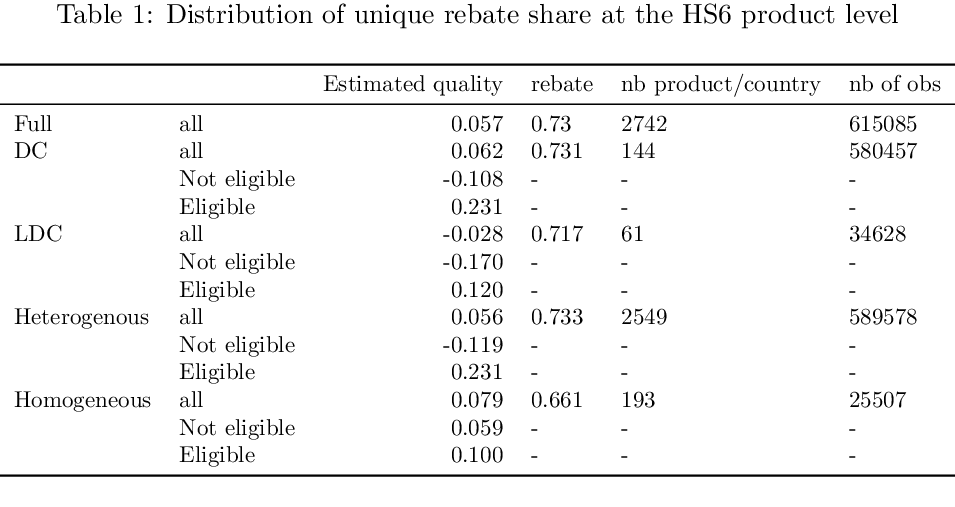

In [55]:
folder = 'Figures'
table_number = 1
title = 'Distribution of unique rebate share at the HS6 product level'
tb_note = """

"""
with open('{}/table_{}.tex'.format(folder,table_number), 'w') as fout:
    for i in range(len( t_final.to_latex(index=True,float_format="{:0.3f}".format))):
        if i ==0:
            header= "\documentclass[preview]{standalone} \n\\usepackage[utf8]{inputenc}\n" \
            "\\usepackage{booktabs,caption,threeparttable, siunitx, adjustbox}\n\n" \
            "\\begin{document}"
            top =  '\n\\begin{adjustbox}{width=\\textwidth, totalheight=\\textheight-2\\baselineskip,keepaspectratio}\n'
            table_top = "\n\\begin{table}[!htbp] \centering"
            table_title = "\n\caption{%s}\n" % title
            
            fout.write(header)
            fout.write(table_top)
            fout.write(table_title)
            fout.write(top)
           
        fout.write( t_final.to_latex(index=True,float_format="{:0.3f}".format)[i])
    
    bottom =  '\n\\end{adjustbox}\n'
    tb_note_top = "\n\\begin{tablenotes}\n\small\n\item"
    table_bottom = "\n\end{table}"
    footer = "\n\n\\end{document}"
    tb_note_bottom = "\n\end{tablenotes}"
    fout.write(bottom)
    fout.write(tb_note_top)
    fout.write(tb_note)
    fout.write(tb_note_bottom)
    fout.write(table_bottom)
    fout.write(footer)
 
f = open('{}/table_{}.tex'.format(folder,table_number))
r = tex2pix.Renderer(f, runbibtex=False)
r.mkpdf('{}/table_{}.pdf'.format(folder,table_number))
img = WImage(filename='{}/table_{}.pdf'.format(folder,table_number),
resolution = 200)
display(img)

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
sns.set(style="whitegrid")

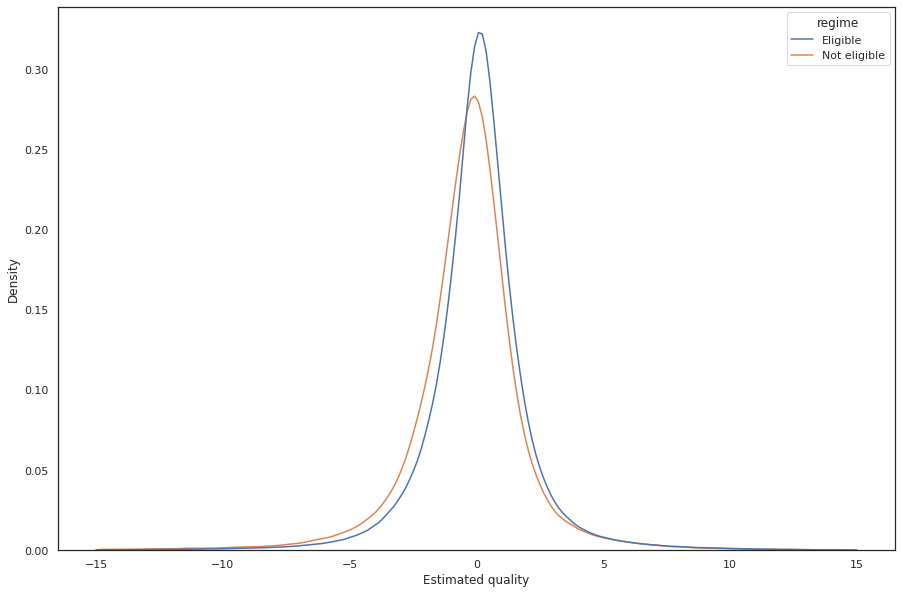

In [58]:
plt.figure(figsize = (15,10))
var = 'kandhelwal_quality'
temp = (
    df_quality_stat
    .replace({'regime':{'ELIGIBLE':'Eligible','NOT_ELIGIBLE':'Not eligible'}})
    .groupby(['regime'])
    .sample(frac = .5)
    .reindex(columns = ['regime',var])
    .loc[lambda x: x[var] < 15]#df_quality_stat[var].describe(percentiles = [.95])['95%']]
    .loc[lambda x: x[var] > -15]#df_quality_stat[var].describe(percentiles = [.05])['5%']]
    .rename(columns = {'kandhelwal_quality':'Estimated quality'})
    
)
sns.set(style="white")

# Without transparency
sns.kdeplot(data=temp, x='Estimated quality', hue="regime", cut=0, fill=False, common_norm=False, alpha=.5)
plt.savefig("Figures/fig_2.png",
            bbox_inches='tight',
            dpi=600)
#plt.show()

Replicate previous table

In [59]:
query = """
WITH temp AS (
SELECT distinct(hs6), year, lag_vat_reb_m/lag_vat_m as rebate
FROM {}.{}  
)
SELECT year, hs6, rebate
FROM temp
ORDER BY hs6
""".format(db, table)

df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig1',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'hs6':'string'}
)
      .loc[lambda x: x['hs6'].isin(df_final['hs6'].unique())]
     )
df.head()

,year,hs6,rebate
56,2010,100630,0.0
57,2008,100630,0.5
58,2007,100630,1.0
59,2006,100630,1.0
60,2005,100630,1.0


In [60]:
df_latex = (
    pd.concat(
    [
        (
            df
            .groupby("year")["rebate"]
            .describe()
            .assign(
                count=lambda x: x["count"].astype("int"),
                max=lambda x: x["max"].astype("int"),
            )
            .apply(lambda x: round(x, 2))
        ),
        (df
         .groupby("year").agg({"rebate": "nunique"})),
    ],
    axis=1,
    # 
)
    .rename(columns = {'rebate':'unique rebate'})
    .reindex(columns = ['count','unique rebate', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       ])
    .to_latex()
)

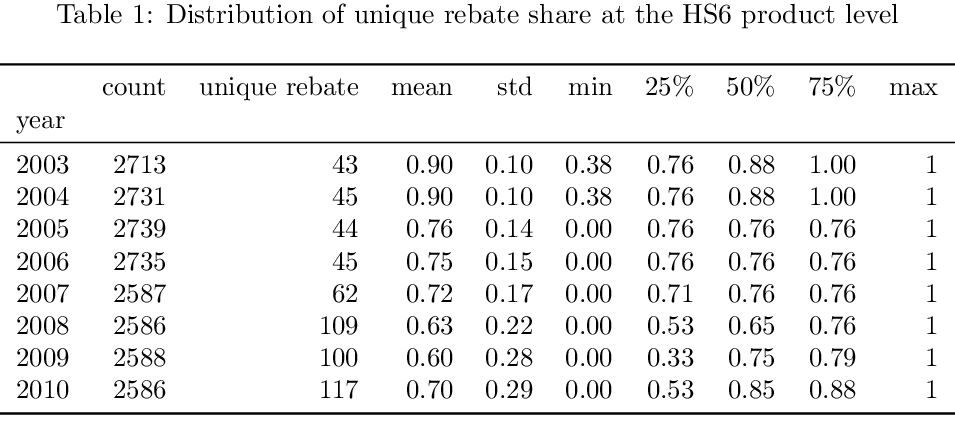

In [61]:
folder = 'Figures'
table_number = 2
title = 'Distribution of unique rebate share at the HS6 product level'
tb_note = """

"""
with open('{}/table_{}.tex'.format(folder,table_number), 'w') as fout:
    for i in range(len( df_latex)):
        if i ==0:
            header= "\documentclass[preview]{standalone} \n\\usepackage[utf8]{inputenc}\n" \
            "\\usepackage{booktabs,caption,threeparttable, siunitx, adjustbox}\n\n" \
            "\\begin{document}"
            top =  '\n\\begin{adjustbox}{width=\\textwidth, totalheight=\\textheight-2\\baselineskip,keepaspectratio}\n'
            table_top = "\n\\begin{table}[!htbp] \centering"
            table_title = "\n\caption{%s}\n" % title
            
            fout.write(header)
            fout.write(table_top)
            fout.write(table_title)
            fout.write(top)
           
        fout.write( df_latex[i])
    
    bottom =  '\n\\end{adjustbox}\n'
    tb_note_top = "\n\\begin{tablenotes}\n\small\n\item"
    table_bottom = "\n\end{table}"
    footer = "\n\n\\end{document}"
    tb_note_bottom = "\n\end{tablenotes}"
    fout.write(bottom)
    fout.write(tb_note_top)
    fout.write(tb_note)
    fout.write(tb_note_bottom)
    fout.write(table_bottom)
    fout.write(footer)
 
f = open('{}/table_{}.tex'.format(folder,table_number))
r = tex2pix.Renderer(f, runbibtex=False)
r.mkpdf('{}/table_{}.pdf'.format(folder,table_number))
img = WImage(filename='{}/table_{}.pdf'.format(folder,table_number),
resolution = 200)
display(img)

In [ ]:
pd.DataFrame({
    'hs6':df_final['hs6'].unique()
}).to_csv('hs6.csv', index = False)

# compute fixed effect

| Benchmark | Origin            | Name                     | Description                                                                                                                                                                                                                                                                                                                                    | Math_notebook     |
|-----------|-------------------|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------|
| Yes       | Current           | city-product             |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}$     |
| Yes       | Current           | city-product-regime      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}^R$   |
| Yes       | Current           | city-sector-year         | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}$    |
| Yes       | Current           | city-sectorーregime-year | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}^R$  |
| Yes       | Current           | product-destination      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{pj}$     |
| Yes       | Previous baseline | Product-year             | account for all factors that affect product-level export irrespective of the trade regime in a given year                                                                                                                                                                                                                                      | $\alpha_{pt}$     |
| No        | Previous baseline | firm-product-eligibility | captures all the factors that affect firms regardless of the time and type of regime. This firm‒product pair eliminates the demand shocks that firms face and that are not correlated with the types of status. The fixed effects are also responsible for potential correlations between subsidies, R&D, or trade policies and VAT rebates.   | $\alpha^{E}_{it}$ |
| No        | Previous baseline | HS4-year-eligibility     |                                                                                                                                                                                                                                                                                                                                                | $\alpha^{E}_{st}$ |
| No        | Previous baseline | city-year                | captures the differences in demand, capital intensity, or labor supply that prevail between cities each year                                                                                                                                                                                                                                   | $\alpha_{ct}$     |
| No        | Candidate         | destination-year         | Captures additional level of control, encompassing all the shocks and developments in the economies to which China exports.                                                                                                                                                                                                                    | $\alpha_{dt}$     |


Create the following fixed effect for the baseline regression:

**index**

* city: `c`
* product: `k`
* sector: `s`
* year: `t`
* Destination: `j`
* regime: `r`

**FE**

* city-product: `FE_ck`
* City-sector-year: `FE_cst`
* City-product-regime: `FE_ckr`
* City-sector-regime-year: `FE_csrt`
* Product-year: `FE_kt`
* Product-destination: `FE_pj`
* Destination-year: `FE_jt`

<!-- #endregion -->

In [62]:
create_fe = True
if create_fe:
    df_final = df_final#.loc[lambda x: x['cn'] == 2]
    #df = pd.read_csv(df_path, dtype = dtypes)
    ### city-product
    df_final["fe_ck"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs6"].astype('str')
                                       )[0]
    
    ### sector-year
    df_final["fe_st"] = pd.factorize(
                                        df_final["hs4"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]

    ### sector-year
    df_final["fe_ct"] = pd.factorize(
                                        df_final["geocode4_corr"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]
    
    ### City-sector-year
    df_final["fe_cst"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs4"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]

    ### City-product-regime
    df_final["fe_ckr"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs6"].astype('str') +
                                        df_final["regime"].astype('str')
                                       )[0]

    ### City-sector-regime-year
    df_final["fe_csrt"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs4"].astype('str') +
                                        df_final["regime"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]

    ## Product-year
    df_final["fe_kt"] = pd.factorize(df_final["hs6"].astype('str') + 
                                        df_final["year"].astype('str')
                                       )[0]

    ## Product-destination
    df_final["fe_kj"] = pd.factorize(df_final["hs6"].astype('str') + 
                                        df_final["country_en"].astype('str')
                                       )[0]

    ## Destination-year
    df_final["fe_jt"] = pd.factorize(df_final["country_en"].astype('str') + 
                                        df_final["year"].astype('str')
                                       )[0]
    
    ## Destination-year-regime
    df_final["fe_jtr"] = pd.factorize(df_final["country_en"].astype('str') + 
                                        df_final["year"].astype('str') +
                                df_final["regime"].astype('str')
                                
                                       )[0]

    ## city-product-destination
    df_final["fe_ckj"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs6"].astype('str') + 
                                        df_final["country_en"].astype('str')
                                       )[0]
    
    ## product destination regime 
    df_final["fe_kjr"] = pd.factorize(df_final["hs6"].astype('str') + 
                                        df_final["country_en"].astype('str') + 
                                        df_final["regime"].astype('str')
                                       )[0]
    ## Shocks
    df_final["fe_group_shock"] = pd.factorize(
        df_final["hs6"].astype('str') +
        df_final["country_en"].astype('str') + 
        df_final["year"].astype('str'))[0]
    
    df_final.to_csv(os.path.join(path_local, filename + '.csv'), index = False)

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [63]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        {
        'old':'ln\_lag\_tax\_rebate',
        'new':'\\text{Ln VAT export tax}_{k, t-1}'
        },
        {
        'old':'ln\_rebate',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'ln\_rebate\_1',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'ln\_rebate\_2',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'rebate',
        'new':'\\text{VAT refund}_{k, t-1}'
        },
        {
        'old':'regimeELIGIBLE',
        'new':'\\text{Regime}^R'
        },
        {
        'old':'ln\_lag\_import\_tax',
        'new':'\\text{Import tax,}_{k, t-1}'
        },
        {
        'old':'lag\_foreign\_export\_share\_ckr',
        'new':'\\text{Foreign export share}_{ck, t-1}^R'
        },
        {
        'old':'lag\_soe\_export\_share\_ckr',
        'new':'\\text{SOE export share}_{ck, t-1}^R'
        },
        
         {
        'old':'lag\_stock\_ntm',
        'new':'\\text{Stock ntm Chinese import}_{k, t-1}'
        },
        
        {
        'old':'lag\_frequency',
        'new':'\\text{lag frequency}_{ck, t-1}'
        },
        
        {
        'old':'lag\_P',
        'new':'\\text{Prevalence}_{j, t-1}'
        },
        
        {
        'old':'lag\_coverage',
        'new':'\\text{lag coverage}_{ck, t-1}'
        },
        {
        'old':'c\_lag\_stock\_ntm\_w',
        'new':'\\text{Stock ntm destination country}_{jk, t-1}'
        },
        {
        'old':'d\_credit\_needs',
        'new':'\\text{Credit needs}_{k}'
        }
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [64]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [65]:
options(warn=-1)
library(tidyverse)
#library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [66]:
library(lfe)

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



In [67]:
library(tidyverse)

In [68]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    regime = relevel(as.factor(regime), ref='NOT_ELIGIBLE'),
    ln_rebate = ln_lag_tax_rebate * (-1),
    ln_rebate_1 = log((lag_vat_reb_m / lag_vat_m) +1),
    ln_rebate_2 = log(lag_vat_reb_m + 1),
    rebate = lag_vat_reb_m / lag_vat_m
      ) 

Parsed with column specification:
cols(
  .default = col_double(),
  regime = col_character(),
  homogeneous = col_character(),
  country_en = col_character(),
  iso_alpha = col_character(),
  income_group = col_character(),
  income_group_ldc_dc = col_character(),
  high_tech = col_logical(),
  energy = col_logical(),
  skilled = col_logical(),
  rd_oriented = col_logical(),
  new_ntm = col_logical(),
  active_ntm = col_logical(),
  new_ntm_china = col_logical(),
  active_ntm_china = col_logical(),
  lag_new_ntm_china = col_logical(),
  lag_active_ntm_china = col_logical(),
  new_ntm_env_china = col_logical(),
  active_ntm_env_china = col_logical(),
  lag_new_ntm_env_china = col_logical(),
  lag_active_ntm_env_china = col_logical()
  # ... with 25 more columns
)
See spec(...) for full column specifications.


In [69]:
df_final %>% select(lag_vat_reb_m, lag_vat_m, rebate) %>% head(2)

lag_vat_reb_m,lag_vat_m,rebate
13,17,0.7647059
13,17,0.7647059


In [ ]:
#df_final %>% group_by(regime) %>%summarize(mean(lag_F_C))

In [70]:
dim(df_final)

[1] 615085    146

In [71]:
df_final.head()

,geocode4_corr,year,regime,hs6,hs4,hs3,hs2,homogeneous,country_en,iso_alpha,gni_per_capita,gpd_per_capita,income_group,income_group_ldc_dc,quantity,value,unit_price,kandhelwal_quality,price_adjusted_quality,lag_vat_m,lag_vat_reb_m,lag_tax_rebate,ln_lag_vat_m,ln_lag_vat_reb_m,ln_lag_tax_rebate,lag_import_tax,ln_lag_import_tax,lag_soe_export_share_ckr,lag_foreign_export_share_ckr,high_tech,energy,skilled,rd_oriented,cn,count_ntm,stock_ntm,new_ntm,active_ntm,c_count_ntm_china,c_stock_ntm_china,new_ntm_china,active_ntm_china,c_lag_count_ntm_china,c_lag_stock_ntm_china,lag_new_ntm_china,lag_active_ntm_china,c_count_ntm_env_china,c_stock_ntm_env_china,new_ntm_env_china,active_ntm_env_china,c_lag_count_ntm_env_china,c_lag_stock_ntm_env_china,lag_new_ntm_env_china,lag_active_ntm_env_china,c_count_ntm_TBT_china,c_stock_ntm_TBT_china,new_ntm_TBT_china,active_ntm_TBT_china,c_lag_count_ntm_TBT_china,c_lag_stock_ntm_TBT_china,lag_new_ntm_TBT_china,lag_active_ntm_TBT_china,c_count_ntm_SPS_china,c_stock_ntm_SPS_china,new_ntm_SPS_china,active_ntm_SPS_china,c_lag_count_ntm_SPS_china,c_lag_stock_ntm_SPS_china,lag_new_ntm_SPS_china,lag_active_ntm_SPS_china,c_count_ntm_TBT_SPS_china,c_stock_ntm_TBT_SPS_china,new_ntm_TBT_SPS_china,active_ntm_TBT_SPS_china,c_lag_count_ntm_TBT_SPS_china,c_lag_stock_ntm_TBT_SPS_china,lag_new_ntm_TBT_SPS_china,lag_active_ntm_TBT_SPS_china,c_count_ntm_ADP_china,c_stock_ntm_ADP_china,new_ntm_ADP_china,active_ntm_ADP_china,c_lag_count_ntm_ADP_china,c_lag_stock_ntm_ADP_china,lag_new_ntm_ADP_china,lag_active_ntm_ADP_china,c_count_ntm_dvp_china,c_stock_ntm_dvp_china,new_ntm_dvp_china,active_ntm_dvp_china,c_lag_count_ntm_dvp_china,c_lag_stock_ntm_dvp_china,lag_new_ntm_dvp_china,lag_active_ntm_dvp_china,DM,M,F,lag_DM,lag_F,NM,P,lag_NM,lag_P,DV,V,C,lag_DV,lag_C,c_count_ntm_w,c_stock_ntm_w,new_ntm_w,active_ntm_w,c_lag_count_ntm_w,c_lag_stock_ntm_w,lag_new_ntm_w,lag_active_ntm_w,kandhelwal_quality3,kandhelwal_quality5,kandhelwal_quality10,concordance_hs,Industry,ext_finance_m,inventory_ratio_m,asset_tangibility_m,trade_credit_intensity_m,liquidity_needs_m,ext_finance_j,liquidity_needs_j,rd_intensity_j,fe_ck,fe_st,fe_ct,fe_cst,fe_ckr,fe_csrt,fe_kt,fe_kj,fe_jt,fe_jtr,fe_ckj,fe_kjr,fe_group_shock
0,3101,2007,NOT_ELIGIBLE,950510,9505,950,95,HETEREGENEOUS,Brazil,BRA,6190.0,10293.530,Upper middle income,DC,223294,314773,1.40968,-0.838405,1.181768,17.0,13.0,4.0,2.890372,2.639057,1.609438,0.0,0.0,0.00000,0.00000,NaN,NaN,NaN,NaN,2,1.0,8.0,TRUE,TRUE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,1.0,4.0,TRUE,TRUE,0.0,3.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,3456.0,4855.0,0.711843,3559.0,0.712227,21864.0,4.503399,21000.0,4.202522,1.025512e+08,1.310309e+08,0.782649,8.131801e+07,0.790426,1.0,8.0,TRUE,TRUE,4.0,7.0,TRUE,TRUE,-3.267794,0.043473,-0.459117,390,Other manufactured products,0.28,0.2,0.18,0.08,0.22,0.47,0.22,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4403,2010,NOT_ELIGIBLE,950510,9505,950,95,HETEREGENEOUS,Argentina,ARG,9270.0,10385.965,High income: nonOECD,DC,36,43,1.19444,-1.420717,1.598394,17.0,13.0,4.0,2.890372,2.639057,1.609438,0.0,0.0,0.16173,0.43319,NaN,NaN,NaN,NaN,2,0.0,7.0,FALSE,TRUE,0.0,4.0,FALSE,TRUE,0.0,4.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,4.0,FALSE,TRUE,0.0,4.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,4.0,FALSE,TRUE,0.0,4.0,FALSE,TRUE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,0.0,0.0,FALSE,FALSE,4595.0,4595.0,1.000000,4585.0,1.000000,33892.0,7.375843,33797.0,7.371210,5.668906e+07,5.668906e+07,1.000000,3.898920e+07,1.000000,0.0,7.0,FALSE,TRUE,0.0,7.0,FALSE,TRUE,-8.870218,-2.243439,-1.832966,390,Other manufactured products,0.28,0.2,0.18,0.08,0.22,0.47,0.22,0.02,1,1,1,1,1,1,1,1,1,1,1,1,1
2,3201,2007,ELIGIBLE,950510,9505,950,95,HETEREGENEOUS,United States,USA,48500.0,49856.280,High income: OECD,DC,759244,2503878,3.29786,0.03

## Table 1: baseline estimate

$$\begin{aligned} \text{Quality}_{c,k,j, t}^{R} &=\alpha \ln \text{VAT Rebate}_{k, t-1} \times \text { Eligibility }^{R} +\alpha \ln \text{Import tax} \times \text { Eligibility }^{R} +X_{c, s, t-1}^{R}+F E_{c,k}^{R}+F E_{k,t}+F E_{j,t}+\epsilon_{c,k,j, t}^{R} \end{aligned} $$

 
Use ln_rebate_1 = log((lag_vat_reb_m / lag_vat_m) +1)  → share of rebate and FE → fe_ckr  + fe_kt + fe_jtr

* Baseline estimate
* Baseline estimate with more controls
* Controlling for product-country-year trends
* cities presents all years
* Keep rebates 17%
* Exclude rebates 0% 

### Quality

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
#pd.read_csv('NTM_HS1996.csv')

In [ ]:
%get path table
### Quality
t_0 <- felm(kandhelwal_quality ~rebate + ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ck  + hs6 + fe_jt|0|hs6, df_final %>% filter(regime != 'ELIGIBLE'),
            exactDOF = TRUE)

t_1 <- felm(kandhelwal_quality ~rebate + ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ck  + hs6 + fe_jt|0, df_final %>% filter(regime == 'ELIGIBLE'),
            exactDOF = TRUE)

### focus coef -> benchmark
#t_2 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
#           | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final,
#            exactDOF = TRUE)
#t_2 <- change_target(t_2)
print('table 0 done')

t_3 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 1 done')

t_4 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr + fe_group_shock|0 | hs6, df_final,
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 2 done')

t_5 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% group_by(geocode4_corr) %>%
  mutate(length = length(unique(year))) %>%
  filter(length ==8),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 3 done')

t_6 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(lag_vat_m==17),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
print('table 4 done')

t_7 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(lag_vat_reb_m != 0),
            exactDOF = TRUE)
t_7 <- change_target(t_7)
print('table 5 done')
t_8 <- felm(kandhelwal_quality3 ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_8 <- change_target(t_8)
print('table 6 done')

t_9 <- felm(kandhelwal_quality5 ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_9 <- change_target(t_9)
print('table 6 done')

t_10 <- felm(kandhelwal_quality10 ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr + fe_group_shock|0 , df_final,
            exactDOF = TRUE)
t_10 <- change_target(t_10)


dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("product",
      "Yes", "Yes", "No", "No", "No","No", "No","No", "No","No"
     ),
    c("City-product-regime",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes", "Yes","Yes"
     ),
    c("Product-year",
      "No", "No", "Yes", "Yes", "Yes","Yes", "Yes","Yes", "Yes","Yes"
     ),
    c("Destination-year",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes", "Yes","Yes"
     )
)

table_1 <- go_latex(list(
    t_0,t_1, #t_2,
    t_3, t_4,t_5,t_6, t_7, t_8, t_9,t_10
    #, t_8, t_9, t_10, t_11
),
    title="VAT export rebate and product's quality upgrading, baseline regression",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(XX)." \
" Ln VAT rebate is the share entitled to reimboursement at the HS6 product." \
" Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group." \
" Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund." \
" Sectors are defined following the Chinese 4-digit GB/T industry." \
" classification and regroup several products." \
" Heteroskedasticity-robust standard errors." \
" clustered at the product level appear inparentheses."\
" \sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Quality': 4,
    #'Price-adjusted': 5,
#}
multicolumn ={
    'Non eligible':1,
    'Eligible':1,
    'Baseline':1,
    'Shocks': 1,
    'Balance': 1,
    'Only 17\%': 1,
    'No zero rebate': 1,
    'Sigma 3': 1,
    'Sigma 5': 1,
    'Sigma 10': 1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = [
    #'& Eligible', 'Non-Eligible', 
    '& All','All benchmark', 'All', 'All benchmark',
    #'Eligible', 'Non-Eligible', 'All','All benchmark', 'All', 'All benchmark',
]

reorder = {
    4:0,
    5:1
}

lb.beautify(table_number = table_nb,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

## Table 2: Heterogeneity effect

- LDC and DC comes from the world bank classification, and are already in the table
- The list of homogeneous goods is in the S3
- Small/large city is be computed by using:
    - the number of product exported in 2003. If the count of product is above average, then it can be consider as a large firm 
    - The average quantity
 
 
* Column 1: Estimate baseline regression subset LDC countries: `income_group_ldc_dc` -> `LDC`
* Column 2: Estimate baseline regression subset DC countries: `income_group_ldc_dc` -> `DC`
* Column 3: Estimate baseline regression subset Homogeneous goods: `classification` -> `HOMOGENEOUS`
* Column 4: Estimate baseline regression subset heterogeneous goods: `classification` -> != `HOMOGENEOUS`
* Column 5: Estimate baseline regression subset small cities: `size_product` -> == `SMALL_COUNT`
* Column 6: Estimate baseline regression subset large cities: `size_product` -> == `LARGE_COUNT`
* Column 7: Estimate baseline regression subset small cities: `size_quantity` -> == `SMALL_QUANTITY`
* Column 8: Estimate baseline regression subset large cities: `size_quantity` -> == `LARGE_QUANTITY`

Sector is defined as the GBT 4 digits

In [ ]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
temp <- df_final %>% 
filter(year == "2003") %>%
#group_by(year, geocode4_corr, hs2) %>%
group_by(geocode4_corr, hs4) %>%
summarize(sum_quantity = sum(quantity), sum_value = sum(value)) %>%
ungroup %>%
group_by(geocode4_corr) %>%
mutate(
    national_avg_q = mean(sum_quantity),
    national_m_q = median(sum_quantity),
    national_d_q =quantile(sum_quantity,probs = .75),
    national_avg_v = mean(sum_value),
    national_m_v = median(sum_value),
    national_d_v =quantile(sum_value,probs = .75),
    size_q_a = ifelse(sum_quantity > national_avg_q, 'LARGE', 'SMALL'),
    size_q_md = ifelse(sum_quantity > national_m_q, 'LARGE', 'SMALL'),
    size_q_d = ifelse(sum_quantity > national_d_q, 'LARGE', 'SMALL'),
    size_v_a = ifelse(sum_value > national_avg_v, 'LARGE', 'SMALL'),
    size_v_md = ifelse(sum_value > national_m_v, 'LARGE', 'SMALL'),
    size_v_d = ifelse(sum_value > national_d_v, 'LARGE', 'SMALL')
) %>%
right_join(df_final, by = c(
    #'year',
    'geocode4_corr',
    #"hs2",
    "hs4"
)) %>%
mutate(
    size_q_a = replace_na(size_q_a, "SMALL"),
    size_q_md = replace_na(size_q_md, "SMALL"),
    size_q_d = replace_na(size_q_d, "SMALL"),
    size_v_a = replace_na(size_v_a, "SMALL"),
    size_v_md = replace_na(size_v_md, "SMALL"),
    size_v_d = replace_na(size_v_d, "SMALL")
)

In [ ]:
dim(df_final 
    %>% filter(is.na(homogeneous) | homogeneous == 'HOMOGENEOUS')%>% 
     filter(kandhelwal_quality > -15)%>%
     filter(kandhelwal_quality <15)
   )

In [ ]:
%get path table
#### COUNTRIES
t_0 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(income_group_ldc_dc == 'LDC'),
            exactDOF = TRUE)
t_0 <- change_target(t_0)
print('table 0 done')

t_1 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(income_group_ldc_dc != 'LDC'),
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')
#### GOODS
t_2 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(homogeneous) | homogeneous == 'HOMOGENEOUS'),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')

t_3 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(homogeneous == 'HETEREGENEOUS'),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 3 done')
#### CITIES
##### city-industry
t_4 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, temp %>% filter(size_q_d == 'SMALL'),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 4 done')

t_5 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, temp %>% filter(size_q_d == 'LARGE'),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 5 done')

##### Quantity
#t_6 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(size_quantity == 'SMALL_QUANTITY'),
#            exactDOF = TRUE)
#t_6 <- change_target(t_6)
#print('table 6 done')

#t_7 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(size_quantity == 'LARGE_QUANTITY'),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
#print('table 7 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes", "Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes", "Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="VAT export tax and firm’s quality upgrading, characteristics of the destination countries, products, and cities",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
LDC and DC are defined according to the World Bank country classification.
Homogeneous and heterogeneous goods are defined according to the official list of goods`s classification, Rauch (1999).
Small and large are computed based on the total quantity exported by city-HS4.
When oto total export by city-HS4 above the city average, then the pair city-industry is considered as large.
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'LDC': 1,
    'DC': 1,
    'Homogeneous': 1,
    'Heterogeneous': 1,
    'Small': 1,
    'Large': 1
}
multi_lines_dep = '(city/product/trade regime/year)'
reorder = {
    2:0,
    3:1
}
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
           folder = folder)

## Table 3: Industry characteristicts

* Column 1 excludes rare earth products with the main fixed effect:
* Column 2 excludes energy intensive industries with the main fixed effect:
* Column 3 excludes high tech industries with the main fixed effect:
* Column 4 excludes RD oriented indusrtries with the main fixed effect:
* Column 5 excludes High skilled oriented with the main fixed effect:
  
Sector is defined as the GBT 4 digits

In [ ]:
folder = 'Tables_0'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

### Download polluted sectors

In [ ]:
db = 'environment'
query = """
WITH temp AS (
SELECT ind2, SUM(tso2) as sum_tso2, SUM(tso2) / SUM(ttoutput) as so2_intensity 
FROM environment.china_city_sector_pollution  
WHERE year = '2002'
GROUP BY ind2
ORDER BY sum_tso2
  )
  SELECT *
  FROM temp
  LEFT JOIN (
    SELECT cic as ind2, short
    FROM chinese_lookup.ind_cic_2_name
    ) as ind_name
    ON temp.ind2 = ind_name.ind2
"""
list_polluted = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='polluted',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_polluted

In [ ]:
(
    list_polluted.assign(
        polluted = lambda x: x['sum_tso2'] >=np.quantile(x['sum_tso2'], 0.5),
        polluted_int = lambda x: x['so2_intensity'] >=np.quantile(x['so2_intensity'], 0.5),
    )
    .reindex(columns = ['ind2', 'short', 'polluted', 'polluted_int'])
    .rename(columns = {'indus_code':'hs4','ind2':'hs2'})
    .to_csv('polluted_vs_no_polluted.csv', index = False)
)

In [ ]:
df_final_polluted <-  df_final %>% left_join(
    read_csv('polluted_vs_no_polluted.csv',
             col_types = cols(hs2 = col_double()))
) %>%
mutate_at(c('polluted', 'polluted_int'), ~replace(., is.na(.), FALSE))

In [ ]:
table(df_final_polluted$polluted)

In [ ]:
table(df_final_polluted$polluted_int)

### Download high tech sectors

- We use the economic complexity: https://atlas.cid.harvard.edu/rankings/product and saved in Google Drive: [Product Complexity Rankings 1995 - 2019](https://docs.google.com/spreadsheets/d/1Jzef1jfTT-vMn80cQz1pVgF85QAIxKVIKZhbMUvYxT8/edit?usp=sharing)
- see paper: https://www.atlantis-press.com/article/55913101.pdf

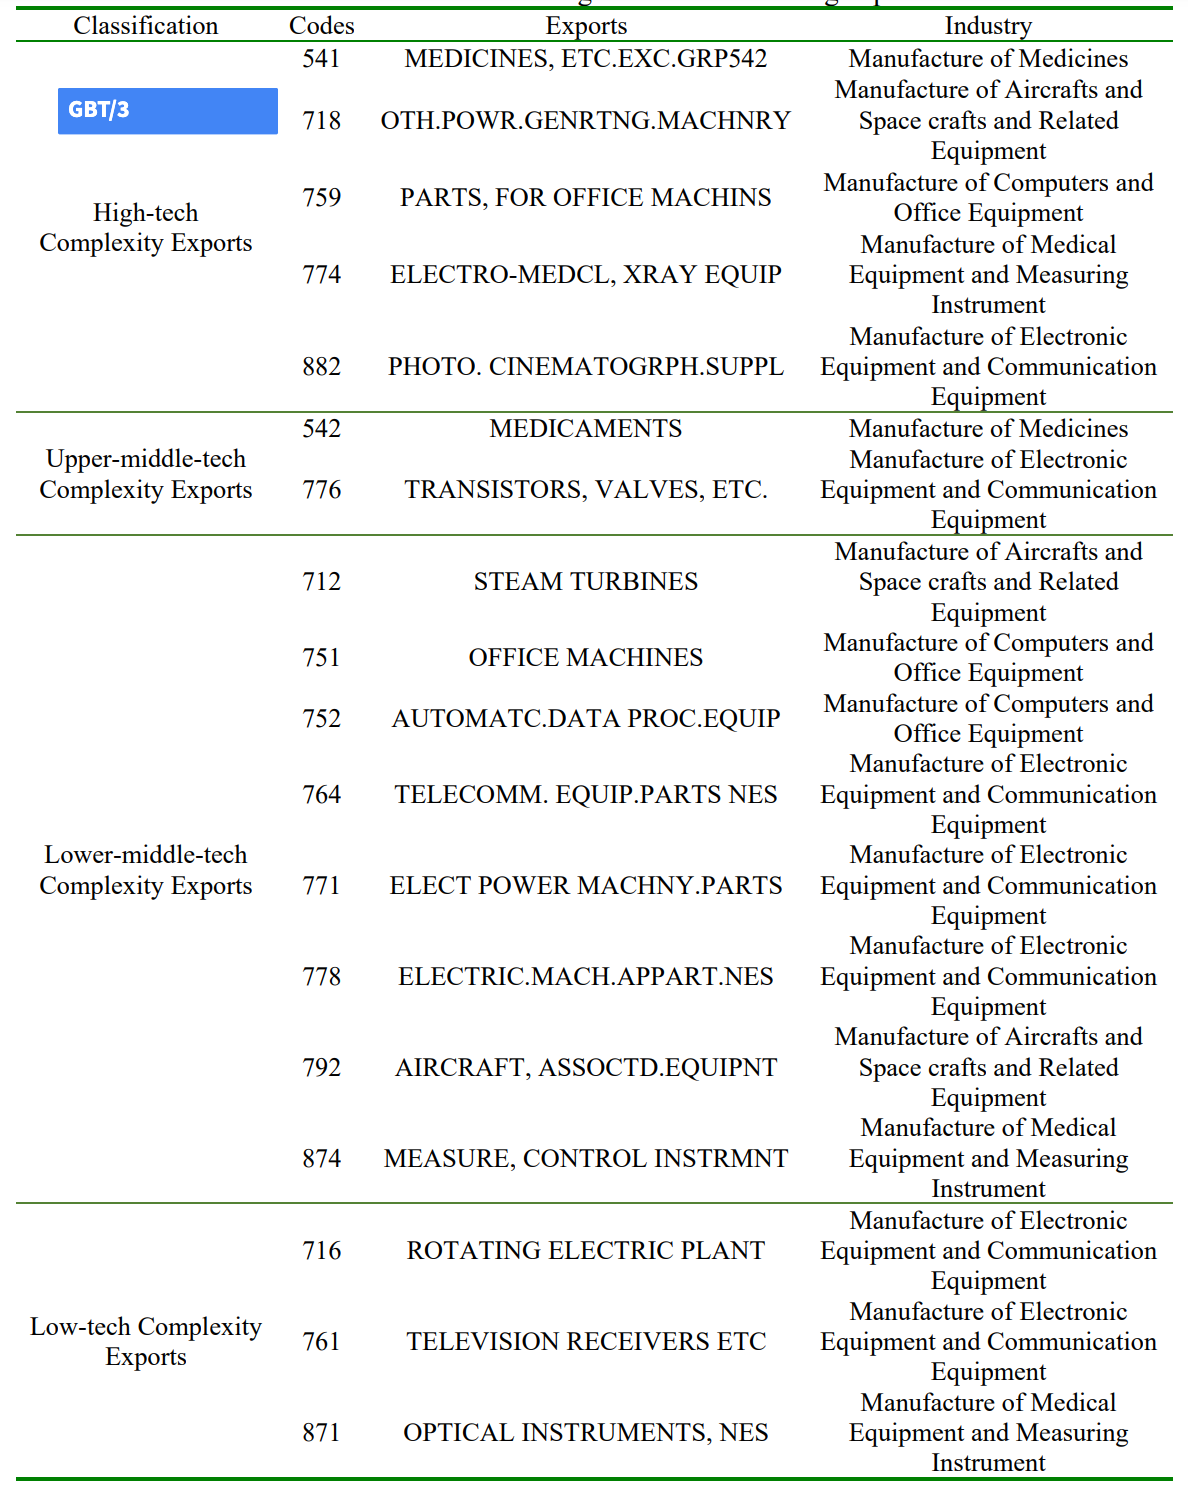

In [ ]:
#!pip install git+https://github.com/thomaspernet/GoogleDrive-python.git

In [ ]:
from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_authorization import authorization_service
import os
import numpy as np
import pandas as pd

In [ ]:
try:
    os.mkdir("creds")
except:
    pass

In [ ]:
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle", path_local = "creds")

In [ ]:
auth = authorization_service.get_authorization(
    #path_credential_gcp=os.path.join(parent_path, "creds", "service.json"),
    path_credential_drive=os.path.join(os.getcwd(), "creds"),
    verbose=False,
    scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
           "https://www.googleapis.com/auth/drive"]
)
gd_auth = auth.authorization_drive(path_secret=os.path.join(
    os.getcwd(), "creds"))
drive = connect_drive.drive_operations(gd_auth)

In [ ]:
FILENAME_SPREADSHEET = "Product Complexity Rankings 1995 - 2019"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)
df_complexity = (
    drive.download_data_from_spreadsheet(
        sheetID=spreadsheet_id,
        sheetName="Product Complexity Rankings 1995 - 2019.csv",
        to_dataframe=True,
    )
    .rename(columns={"PCI 2002": "PCI_2002"})
    .assign(PCI_2002=lambda x: pd.to_numeric(x["PCI_2002"]))
    .assign(
        hs4=lambda x: np.where(
            x["HS4 Code"].astype("str").str.len() == 3,
            "0" + x["HS4 Code"].astype("str"),
            x["HS4 Code"].astype("str"),
        ),
        rank_2002=lambda x: pd.qcut(
            x["PCI_2002"], 4, labels=["Low-tech Complexity", 
                                      "Lower-middle-tech",
                                      "Upper-middle-tech",
                                     "High-tech"]
        ),
        dummy_tech_1 = lambda x: x['rank_2002'].isin(["Upper-middle-tech",
                                     "High-tech"]), # 50%
        dummy_tech_2 = lambda x: x['rank_2002'].isin(["High-tech"]), #75%
        dummy_tech_3 = lambda x:  x['PCI_2002'] >=0.910580, #80%
        dummy_tech_4 = lambda x:  x['PCI_2002'] >=1.271060, #90%
        dummy_tech_5 = lambda x:  x['PCI_2002'] >=1.535260 #95%
    )
)
df_complexity.to_csv('rank_complexity.csv', index = False)

In [ ]:
df_complexity.head(2)

In [ ]:
df_complexity['PCI_2002'].describe(percentiles= [.75, .80, .90, .95])

In [ ]:
df_complexity.groupby('rank_2002')['PCI_2002'].describe()

In [ ]:
df_complexity.loc[lambda x: x['rank_2002'].isin(['High-tech'])].sort_values(by = ['PCI_2002']).tail()['Product']

In [ ]:
df_final_1 <- df_final %>% 
left_join(read_csv('rank_complexity.csv',
                                           col_types = cols(
                                               hs4 = col_double()
                                           )
                                          )%>%select(Product,
                                           hs4,
                                           rank_2002,
                                           dummy_tech_1,
                                           dummy_tech_2,
                                           dummy_tech_3,
                                                     dummy_tech_4,
                                                     dummy_tech_5
                                                    )) %>%
mutate_at(c('rank_2002'), ~replace(., is.na(.), 'Low-tech Complexity'))%>%
mutate_at(c('dummy_tech_1',
            'dummy_tech_2',
            'dummy_tech_3',
            'dummy_tech_4',
            'dummy_tech_5'
           ), ~replace(., is.na(.), FALSE),
         )


In [ ]:
table(df_final_1$dummy_tech_1)

In [ ]:
table(df_final_1$dummy_tech_2)

In [ ]:
table(df_final_1$dummy_tech_3)

In [ ]:
table(df_final_1$dummy_tech_4)

In [ ]:
table(df_final_1$dummy_tech_5)

### Download RD oriented

In [ ]:
query = """
WITH test AS (
SELECT SUBSTRING(cic, 1, 2) as hs2,
SUM(rdfee) as rdfee,
SUM(total_asset) as total_asset,
CAST(
          SUM(rdfee) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) AS rd_total_asset,
CAST(
          SUM(rdfee) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(output) AS DECIMAL(16, 5)
          ), 
          0
        ) AS rd_output
FROM (
SELECT 
cic, rdfee,output,  CASE WHEN (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) - (c95 + c97 + c99) > 0 THEN (c95 + c97 + c99) + ABS(
      (
        c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
      ) - (c95 + c97 + c99)
    ) ELSE (c95 + c97 + c99) END AS total_right, 
    CASE WHEN (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) - (c95 + c97 + c99) < 0 THEN (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) + ABS(
      (
        c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
      ) - (c95 + c97 + c99)
    ) ELSE (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) END AS total_asset
    FROM firms_survey.asif_firms_prepared  
WHERE year = '2005'
)
GROUP BY SUBSTRING(cic, 1, 2)
ORDER BY rd_total_asset
) 
SELECT *
FROM test
LEFT JOIN (
    SELECT cic as ind2, short
    FROM chinese_lookup.ind_cic_2_name
    ) as ind_name
    ON test.hs2 = ind_name.ind2
"""
list_rd = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='rd',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_rd

In [ ]:
(
    list_rd
    .assign(
        #hs4=lambda x: np.where(
        #    x["cic"].astype("str").str.len() == 3,
        #    "0" + x["cic"].astype("str"),
        #   x["cic"].astype("str"),
        #),
        rd_asset = lambda x: x['rd_total_asset'] >=np.quantile(x['rd_total_asset'], 0.75),
        rd_output = lambda x: x['rd_output'] >=np.quantile(x['rd_output'], 0.75)
    )
    .reindex(columns = [
        #'hs4',
        'hs2', 'rd_asset', 'rd_output', 'short'
    ])
    .to_csv('rd_vs_no_rd.csv', index = False)
)

In [ ]:
df_final_rd <-  df_final %>% left_join(
    read_csv('rd_vs_no_rd.csv',
             col_types = cols(
                 hs2 = col_double(),
                 hs4 = col_double()
             ))
) %>%
mutate_at(c('rd_asset','rd_output'), ~replace(., is.na(.), FALSE))

In [ ]:
table(df_final_rd$rd_output)

In [ ]:
table(df_final_rd$rd_asset)

### Dummy

In [ ]:
%get path table
t_1 <- felm(kandhelwal_quality ~rebate* regime* polluted + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_polluted,
            exactDOF = TRUE)
t_1 <- change_target(t_1)

print('table 1 done')
t_2 <- felm(kandhelwal_quality ~rebate* regime * dummy_tech_2 + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_1,
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')

t_3 <- felm(kandhelwal_quality ~rebate* regime * rd_output + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_rd,
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 4 done')
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_1, t_2, t_3
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'Rare-earth': 2,
    'Polluted intensive': 2,
    'High tech': 2,
    'RD oriented': 2,
    'High skilled oriented': 2
}
reorder = {
    2:0,
    3:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

### subset

In [ ]:
folder = 'Tables_0'
table_nb = 4
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')

In [ ]:
%get path table
#### RARE HEARTH
#t_0 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(hs6 != 850511),
#            exactDOF = TRUE)
#t_0 <- change_target(t_0)
#print('table 0 done')

#t_1 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(hs6 == 850511),
#            exactDOF = TRUE)
#t_1 <- change_target(t_1)
#print('table 0 done')

#### NO LARGE POLLUTED INDUSTRY
t_1 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_polluted %>% filter(polluted == TRUE),
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')

t_2 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_polluted %>% filter(polluted == FALSE),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 1 done')

#### LARGEST COMPLEXITY ->ONE WITH BEST POTENTIAL
t_3 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_1 %>% filter(dummy_tech_2 == TRUE),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 2 done')

t_4 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_1 %>% filter(dummy_tech_2 == FALSE),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 2 done')
#### SKILLED
#t_6 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(skilled)),
#            exactDOF = TRUE)
#t_6 <- change_target(t_6)
#print('table 3 done')

#t_7 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(!is.na(skilled)),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
#print('table 3 done')
##### RD
t_5 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_rd %>% filter(rd_output == TRUE),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 3 done')

t_6 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_rd %>% filter(rd_output == FALSE),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
print('table 3 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes","Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_1, t_2, t_3, t_4, t_5, t_6
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    #'Rare-earth': 2,
    'Polluted intensive': 2,
    'High tech': 2,
    'RD oriented': 2,
    #1'High skilled oriented': 2
}
reorder = {
    2:0,
    3:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Yes', 'No', 'Yes', 'No', 'Yes', 'No']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

# Credit Constraint

In [72]:
folder = 'Tables_0'
table_nb = 5
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')

In [ ]:
#pd.read_csv(manova#, usecols = ['ISIC']                    ,
#                    dtype={"ISIC": "str"},
#                ).describe()

In [ ]:
#pd.read_csv(jarreau#, usecols = ['ISIC']                    ,
#                    dtype={"ISIC": "str"},
#                ).describe()

In [ ]:
#df_final[['ext_finance_m','ext_finance_j','rd_intensity_j', 'liquidity_needs_m', 'asset_tangibility_m', "trade_credit_intensity_m"]].describe()

In [73]:
%get path table
#### External finance J: OK
t_0 <- felm(kandhelwal_quality ~
     rebate* regime * d_credit_needs+ 
     ln_lag_import_tax * regime+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 , df_final %>%
     mutate(d_credit_needs = ifelse(ext_finance_j >0.220000, FALSE, TRUE)),
            exactDOF = TRUE)

### liquidity: OK
t_1 <- felm(kandhelwal_quality ~
     rebate* regime * d_credit_needs+ 
     ln_lag_import_tax * regime+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 , df_final %>%
     mutate(d_credit_needs = ifelse(liquidity_needs_j >0.200000, TRUE, FALSE)),
            exactDOF = TRUE)

### Trade credit 
t_2 <- felm(kandhelwal_quality ~
     rebate* regime * d_credit_needs+ 
     ln_lag_import_tax * regime+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 , df_final %>%
     mutate(d_credit_needs = ifelse(trade_credit_intensity_m >0.080000, FALSE, TRUE)),
            exactDOF = TRUE)

### Asset tangibility
t_3 <- felm(kandhelwal_quality ~
     rebate* regime * d_credit_needs+ 
     ln_lag_import_tax * regime+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 , df_final %>%
     mutate(d_credit_needs = ifelse(asset_tangibility_m >0.220000, FALSE, TRUE)),
            exactDOF = TRUE)

### RD intensity
t_4 <- felm(kandhelwal_quality ~
     rebate* regime * d_credit_needs+ 
     ln_lag_import_tax * regime+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 , df_final %>%
     mutate(d_credit_needs = ifelse(rd_intensity_j >0.010000, FALSE, TRUE)),
            exactDOF = TRUE)
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes","Yes","Yes","Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes","Yes","Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, 
    #t_2,
    t_3, t_4#, t_5#, t_6
),
    title="VAT export tax and firm’s quality upgrading NTM anaysis",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

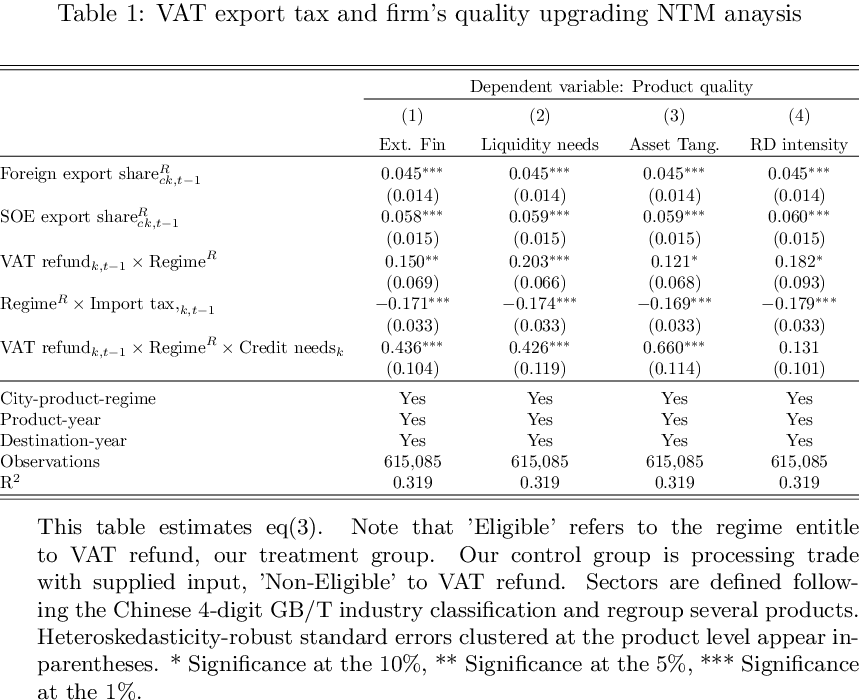

In [74]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'Baseline': 1,
    'Environnement': 1,
    'classification': 3,
    'Developped': 1,
    #'Destination': 1
}
reorder = {
    12:2,
    #5:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Ext. Fin','Liquidity needs',
         #'Trade Credit', 
         'Asset Tang.', 'RD intensity']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

# Non Tariff Measure

- Model is located here: [checkpoint-2562](https://drive.google.com/drive/folders/13rpnm5X5UG-MgLAFb8r1Pu2F-hvGA443?usp=sharing)

In [75]:
folder = 'Tables_0'
table_nb = 6
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')

#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [76]:
%get path table
t_0 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * c_lag_stock_ntm_w + 
    rebate * regime * lag_P + 
    ln_lag_import_tax * regime +
    lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr |0 , df_final %>% 
    rename(lag_stock_ntm = c_lag_stock_ntm_china),
            exactDOF = TRUE)
   
#### ENV
t_1 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * c_lag_stock_ntm_w + 
    rebate * regime * lag_P + 
    ln_lag_import_tax * regime  +
    lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr |0 , df_final %>%
    rename(lag_stock_ntm = c_lag_stock_ntm_env_china),
            exactDOF = TRUE)

### TBT
t_2 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * c_lag_stock_ntm_w + 
    rebate * regime * lag_P + 
    ln_lag_import_tax * regime  +
    lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr |0 , df_final %>%
    rename(lag_stock_ntm = c_lag_stock_ntm_TBT_SPS_china),
            exactDOF = TRUE)

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes","Yes","Yes","Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes","Yes","Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2#, t_3, t_4, t_5#, t_6
),
    title="VAT export tax and firm’s quality upgrading NTM anaysis",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

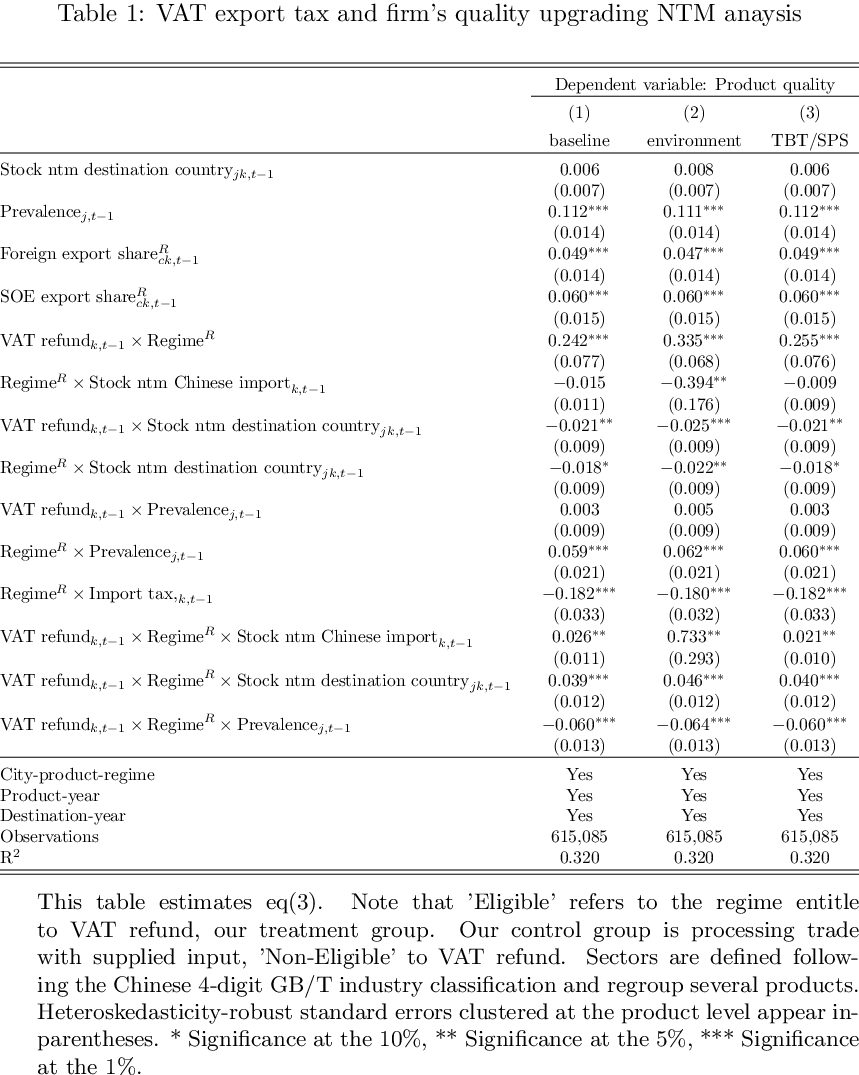

In [77]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'Baseline': 1,
    'Environnement': 1,
    'classification': 3,
    'Developped': 1,
    #'Destination': 1
}
reorder = {
    12:2,
    #5:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& baseline', 'environment', 'TBT/SPS']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc

In [ ]:
name_json = 'parameters_ETL_VAT_rebate_quality_china.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = True, notebookname = "00_baseline_vat_quality.ipynb")

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)